In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as stats
import itertools as it
import math 
import pandas as pd

c:\Users\Ayush\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
##define the fixed parameters
hatchability = 0.98  #if hatchability is density (egg or adult) depedent, then define it in the pre-adult-module or the adult-module functions 
x1 = 2.5  #parameter in finding the mean larval size
x2 = 1  #parameter in finding the mean larval size 
x3 = 0.009 #parameter in finding the mean larval size 
sigma_size = 0.45  #parameter in assigning larval sizes by drawing from a normal distribution
mc = 1.1 #critical size cut off of the larval stage for successful pupation (= 1.1 (JB) and 1 (FEJ))
x4 = 1.0  #parameter in finding the adult sizes
female_proportion = 0.5 #assign sex to the adutls 
x5 = 85 #parameter in finding fecundity
x6 = 2  #parameter in finding fecundity
sen_adsize = 1.7 #parameter related to sensivity of fecundity to adult size
sen_adden = 0.17 #parameter related to sensivity of fecundity to adult denisity
f = 0#migration rate

In [4]:
##Pre-Adult-Module
#food = larval food amt; 1.76 (LL and LH), 2.56 (HL and HH) 


def Pre_Adult_Module(numegg,food):
    """  
This function takes the number of eggs in gen t and larval food amount as input and returns the number of adults in gen t and their size distribution as output.

Args: 
    numegg (int): number of eggs in generation t
    food (float): larval food amount in ml

Returns:
    numadult (int): number of adults in generation t
    size_adult_arr (array): size distribution of adults in generation t
"""
    numlarva = int(hatchability*numegg)
    mean_size = x1*(1-1/(x2+np.exp(-x3*numlarva+food)))
    size_larva_arr = abs(np.random.normal(mean_size, sigma_size, numlarva))
    numadult = (size_larva_arr>=mc).sum()
    size_adult_arr = x4*size_larva_arr[size_larva_arr>=mc]
    return numadult, size_adult_arr

In [5]:
##Demographic-Stochasticity

def Demo_Stoch(numadult, size_adult_arr):
    """  
This function takes the number of adults in gen t and their size distribution, if their number is less than 8 then it is reduced to 0 by 50 % chance

Args: 
    numadult (int): number of adults in generation t before demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t before demographic stochasticity

Returns:
    numadult (int): number of adults in generation t after demographic stochasticity
    size_adult_arr (array): size distribution of adults in generation t after demographic stochasticity
    """
    if numadult < 8:
        numadult = np.random.binomial(size=1, n=1, p=0.5)*numadult # numadult either remains the same or is reduced to 0
        numadult = numadult[0] 
        if numadult == 0:
            size_adult_arr = np.array([])
    return numadult, size_adult_arr


In [6]:
##Female_Size

def Female_Size(size_adult_arr):
    """  
This function takes size_adult_arr as input and returns female_size_arr as output.

Args: 
    size_adult_arr (array): size distribution of adults in generation t

Returns:
    size_female_arr (array): size distribution of only females in generation t
"""
    numadult = np.shape(size_adult_arr)[0]
    adult_sex_arr = np.random.binomial(size=numadult, n=1, p=female_proportion) # 1 is a female and 0 a male
    size_female_arr = size_adult_arr[adult_sex_arr == 1]
    return size_female_arr

In [7]:
##Metapopulation_Reset

def Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2):
    """
This function takes numadult and size_female_arr of both patches post-demo-stoch as inputs and returns numadult and size_female_arr of both patches after metapopulation reset as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t post-demo-stoch pre-metapopulation-reset
    numadult2 (int): number of adults in patch 2 in generation t post-demo-stoch pre-metapopulation-reset   
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-demo-stoch pre-metapopulation-reset
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-demo-stoch pre-metapopulation-reset

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-metapopulation-reset
    numadult2 (int): number of adults in patch 2 in generation t post-metapopulation-reset  
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-metapopulation-reset
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-metapopulation-reset
"""
    if numadult1 == 0 and numadult2 == 0:
        numadult1 = 8 #resetting the population to 4 males and 4 females
        numadult2 = 8
        size_female_arr1 = 2*mc*np.ones(int(numadult1/2))
        size_female_arr2 = 2*mc*np.ones(int(numadult2/2))

    return numadult1,numadult2,size_female_arr1,size_female_arr2

In [8]:
##Migration

def Migration(numadult1,numadult2,size_female_arr1,size_female_arr2):
    """  
This function takes numadult and size_female_arr of both patches as inputs and returns numadult and size_female_arr of both patches post migration as output.

Args: 
    numadult1 (int): number of adults in patch 1 in generation t pre-migration
    numadult2 (int): number of adults in patch 2 in generation t pre-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t pre-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t pre-migration

Returns:
    numadult1 (int): number of adults in patch 1 in generation t post-migration
    numadult2 (int): number of adults in patch 2 in generation t post-migration    
    size_female_arr1 (array): size distribution of females in patch 1 in generation t post-migration
    size_female_arr2 (array): size distribution of females in patch 2 in generation t post-migration
"""
    mig_female_12 = size_female_arr1[(len(size_female_arr1)-round(f*numadult1/2)):]
    #print(mig_female_12)
    mig_female_21 = size_female_arr2[(len(size_female_arr2)-round(f*numadult2/2)):]
    #print(mig_female_21)
    size_female_arr1 = np.concatenate((size_female_arr1[0:(len(size_female_arr1)-round(f*numadult1/2))],mig_female_21))
    #print(size_female_arr1)
    size_female_arr2 = np.concatenate((size_female_arr2[0:(len(size_female_arr2)-round(f*numadult2/2))],mig_female_12))
    #print(size_female_arr2)
    numadult1_update = numadult1 - round(f*numadult1/2) + round(f*numadult2/2)
    numadult2_update = numadult2 - round(f*numadult2/2) + round(f*numadult1/2)
    numadult1 = numadult1_update
    numadult2 = numadult2_update
    return numadult1,numadult2,size_female_arr1,size_female_arr2

In [9]:
##Adult-Module
#adnut = #adult food nutrition quality; 1 (LL and HL), 1.29 (HH) and 1.49 (LH)

def Adult_Module(numadult, size_female_arr,adnut):
    """  
This function takes the number of adults in gen t, the female size distribution and the nutrition quality of adult food as inputs and returns the number of eggs in gen t+1 as output.

Args: 
    numadult (int): number of adults in generation t
    size_female_arr (array): size distribution of females in generation t
    adnut (float): adult food nutrition quality

Returns:
    numegg (int): number of eggs in generation t+1
"""
    addens_ind_fec_arr = adnut*x5*np.log(x6+sen_adsize*size_female_arr)
    addens_eff = 1/(1+sen_adden*numadult)
    fecundity_arr = addens_eff*addens_ind_fec_arr
    fecundity_arr = fecundity_arr.astype(int)
    numegg = fecundity_arr.sum()
    return numegg


In [10]:
##Metapop_Simulation

def Metapop_Simulation(numegg1_start,food1,adnut1,numegg2_start,food2,adnut2,generations,replicates):
    """  
This function takes the number of eggs in gen 1, food amount provided to the larvae in each of the successive gens,
the adult food nutrition quality in each of the successive gens for each subpopulation, 
number of generations for which each simulation will be run and the number of replicate simulations 
that will be run as inputs and returns a matrix of adult population sizes for each generation 
(each column is a replicate simulation and each row is a generation), a matrix of number of 
eggs in each generation and a matrix of extinctions for each replicate for both the subpopulations

Args: 
    numegg1_start (int): number of eggs in generation 1 for patch 1
    food1 (float): larval food amount in ml for patch 1
    adnut1 (float): adult food nutrition quality for patch 1
    numegg2_start (int): number of eggs in generation 1 for patch 2
    food2 (float): larval food amount in ml for patch 2
    adnut2 (float): adult food nutrition quality for patch 2
    generations (int): number of generations for which each simulation will be run
    replicates (int): number of replicate simulations that will be run

Returns:
    numadult_matrix1 (array): array of adult population sizes for each generation 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numegg_matrix1 (array): array of number of eggs in each generation for patch 1
    extinctions_matrix1 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numadult_matrix2 (array): array of adult population sizes for each generation for patch 2
    numegg_matrix2 (array): array of number of eggs in each generation for patch 2
    extinctions_matrix2 (array): array of extinctions for each generation for patch 2
"""
    numadult_matrix1 = np.zeros((generations,replicates)) #array to store the number of adults per generation
    numegg_matrix1 = np.zeros((generations,replicates)) #array to store the number of eggs per generation
    extinctions_matrix1 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen
    numadult_matrix2 = np.zeros((generations,replicates)) 
    numegg_matrix2 = np.zeros((generations,replicates))
    extinctions_matrix2 = np.zeros((generations,replicates))
    for i in range(replicates):
        # 1st generation, we start with numegg1_start and numegg2_start eggs respectively
        numegg1 = numegg1_start
        numegg2 = numegg2_start
        numegg_matrix1[0,i] = numegg1
        numegg_matrix2[0,i] = numegg2
        numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
        #print(numadult1)
        numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
        #print(numadult2)
        numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1) #Where to put demo stoch?
        numadult2,size_adult_arr2  = Demo_Stoch(numadult2,size_adult_arr2) 
        #print(numadult1,numadult2)
        size_female_arr1 = Female_Size(size_adult_arr1)   
        #print(size_female_arr1)
        size_female_arr2 = Female_Size(size_adult_arr2)
        #print(size_adult_arr2)
        if numadult1 == 0 and numadult2 > 0:
            extinctions_matrix1[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 > 0 and numadult2 == 0:
            extinctions_matrix2[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 == 0 and numadult2 == 0: 
            numadult_matrix1[0,i] = 8 
            numadult_matrix2[0,i] = 8
            extinctions_matrix1[0,i] = 1
            extinctions_matrix2[0,i] = 1 
        else:
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
        #print(numadult1,numadult2)
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)

        for j in range(1,generations):
            numegg1 = Adult_Module(numadult1,size_female_arr1,adnut1)
            numegg2 = Adult_Module(numadult2,size_female_arr2,adnut2)
            numegg_matrix1[j,i] = numegg1
            numegg_matrix2[j,i] = numegg2
            numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
            numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
            numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1)
            numadult2,size_adult_arr2 = Demo_Stoch(numadult2,size_adult_arr2)
            size_female_arr1 = Female_Size(size_adult_arr1)
            size_female_arr2 = Female_Size(size_adult_arr2)
            if numadult1 == 0 and numadult2 > 0:
                extinctions_matrix1[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 > 0 and numadult2 == 0:
                extinctions_matrix2[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 == 0 and numadult2 == 0: 
                numadult_matrix1[j,i] = 8
                numadult_matrix2[j,i] = 8
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1 
            else:
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)
    return numadult_matrix1,numegg_matrix1,extinctions_matrix1,numadult_matrix2,numegg_matrix2,extinctions_matrix2

In [11]:
##Metapop_Simulation1

def Metapop_Simulation1(numegg1_start,food1,adnut1,numegg2_start,food2,adnut2,generations,replicates):
    """  
This function takes the number of eggs in gen 1, food amount provided to the larvae in each of the successive gens,
the adult food nutrition quality in each of the successive gens for each subpopulation, 
number of generations for which each simulation will be run and the number of replicate simulations 
that will be run as inputs and returns a matrix of adult population sizes for each generation 
(each column is a replicate simulation and each row is a generation), a matrix of number of 
eggs in each generation and a matrix of extinctions for each replicate for both the subpopulations.
There is no demographic stochasticity in this function.

Args: 
    numegg1_start (int): number of eggs in generation 1 for patch 1
    food1 (float): larval food amount in ml for patch 1
    adnut1 (float): adult food nutrition quality for patch 1
    numegg2_start (int): number of eggs in generation 1 for patch 2
    food2 (float): larval food amount in ml for patch 2
    adnut2 (float): adult food nutrition quality for patch 2
    generations (int): number of generations for which each simulation will be run
    replicates (int): number of replicate simulations that will be run

Returns:
    numadult_matrix1 (array): array of adult population sizes for each generation 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numegg_matrix1 (array): array of number of eggs in each generation for patch 1
    extinctions_matrix1 (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} 
    (each column is a replicate simulation and each row is a generation) for patch 1
    numadult_matrix2 (array): array of adult population sizes for each generation for patch 2
    numegg_matrix2 (array): array of number of eggs in each generation for patch 2
    extinctions_matrix2 (array): array of extinctions for each generation for patch 2
"""
    numadult_matrix1 = np.zeros((generations,replicates)) #array to store the number of adults per generation
    numegg_matrix1 = np.zeros((generations,replicates)) #array to store the number of eggs per generation
    extinctions_matrix1 = np.zeros((generations,replicates)) #array denoting if extinction happened in any given gen
    numadult_matrix2 = np.zeros((generations,replicates)) 
    numegg_matrix2 = np.zeros((generations,replicates))
    extinctions_matrix2 = np.zeros((generations,replicates))
    for i in range(replicates):
        # 1st generation, we start with numegg1_start and numegg2_start eggs respectively
        numegg1 = numegg1_start
        numegg2 = numegg2_start
        numegg_matrix1[0,i] = numegg1
        numegg_matrix2[0,i] = numegg2
        numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
        #print(numadult1)
        numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
        #print(numadult2)
        #numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1) #Where to put demo stoch?
        #numadult2,size_adult_arr2  = Demo_Stoch(numadult2,size_adult_arr2) 
        #print(numadult1,numadult2)
        size_female_arr1 = Female_Size(size_adult_arr1)   
        #print(size_female_arr1)
        size_female_arr2 = Female_Size(size_adult_arr2)
        #print(size_adult_arr2)
        if numadult1 == 0 and numadult2 > 0:
            extinctions_matrix1[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 > 0 and numadult2 == 0:
            extinctions_matrix2[0,i] = 1
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        elif numadult1 == 0 and numadult2 == 0: 
            numadult_matrix1[0,i] = 8 
            numadult_matrix2[0,i] = 8
            extinctions_matrix1[0,i] = 1
            extinctions_matrix2[0,i] = 1 
        else:
            numadult_matrix1[0,i] = numadult1
            numadult_matrix2[0,i] = numadult2
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
        #print(numadult1,numadult2)
        numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)

        for j in range(1,generations):
            numegg1 = Adult_Module(numadult1,size_female_arr1,adnut1)
            numegg2 = Adult_Module(numadult2,size_female_arr2,adnut2)
            numegg_matrix1[j,i] = numegg1
            numegg_matrix2[j,i] = numegg2
            numadult1, size_adult_arr1 = Pre_Adult_Module(numegg1,food1)
            numadult2, size_adult_arr2 = Pre_Adult_Module(numegg2,food2)
            #numadult1,size_adult_arr1 = Demo_Stoch(numadult1,size_adult_arr1)
            #numadult2,size_adult_arr2 = Demo_Stoch(numadult2,size_adult_arr2)
            size_female_arr1 = Female_Size(size_adult_arr1)
            size_female_arr2 = Female_Size(size_adult_arr2)
            if numadult1 == 0 and numadult2 > 0:
                extinctions_matrix1[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 > 0 and numadult2 == 0:
                extinctions_matrix2[j,i] = 1
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            elif numadult1 == 0 and numadult2 == 0: 
                numadult_matrix1[j,i] = 8
                numadult_matrix2[j,i] = 8
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1 
            else:
                numadult_matrix1[j,i] = numadult1
                numadult_matrix2[j,i] = numadult2
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Metapopulation_Reset(numadult1,numadult2,size_female_arr1,size_female_arr2)
            numadult1,numadult2,size_female_arr1,size_female_arr2 = Migration(numadult1,numadult2,size_female_arr1,size_female_arr2)
    return numadult_matrix1,numegg_matrix1,extinctions_matrix1,numadult_matrix2,numegg_matrix2,extinctions_matrix2

In [12]:
#Metapop_matrices

def Metapop_numegg_matrix(numegg_matrix1,numegg_matrix2):
    """
This function takes the numegg_matrix of both patches as inputs and returns the numegg_matrix of the metapopulation as output.

Args:
    numegg_matrix1 (array): array of number of eggs in each generation (patch 1)
    numegg_matrix2 (array): array of number of eggs in each generation (patch 2)

Returns:
    numadult_matrix (array): array of number of eggs in each generation (metapopulation)
"""
    numegg_matrix = numegg_matrix1 + numegg_matrix2
    return numegg_matrix



def Metapop_numadult_matrix(numadult_matrix1,numadult_matrix2):
    """
This function takes the numadult_matrix of both patches as inputs and returns the numadult_matrix of the metapopulation as output.

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)

Returns:
    numadult_matrix (array): array of adult population sizes for each generation (metapopulation)
"""
    numadult_matrix = numadult_matrix1 + numadult_matrix2
    return numadult_matrix


def Metapop_extinctions_matrix(extinctions_matrix1,extinctions_matrix2):
    """
This function takes the extinctions_matrix of both patches as inputs and returns the extinctions_matrix of the metapopulation as output.

Args:
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)

Returns:
    extinctions_matrix (array): array of extinctions for each generation (metapopulation)
"""
    extinctions_matrix = extinctions_matrix1 + extinctions_matrix2
    extinctions_matrix = extinctions_matrix/2
    extinctions_matrix[extinctions_matrix < 1] = 0
    return extinctions_matrix

In [13]:
# prob_extinction_n

def prob_extinction_n(extinctions_matrix,n):
    """  
This function takes the extinctions_matrix, and n (number of generations) as input and returns the probability of extinction happening in the first n generations

Args: 
    extinctions_matrix (array): array of extinctions for each generation {1 if extinction happens and 0 otherwise} (each column is a replicate simulation and each row is a generation)
    n (int): first n number of generations   

Returns:
    prob (0 <= float <= 1): rel. freq of replicates in which we did observe an extinction by the nth generation
"""
    if extinctions_matrix.ndim == 1:
        extinctions_matrix = np.expand_dims(extinctions_matrix, axis=1)
    replicates = np.shape(extinctions_matrix)[1]
    col_sum  = extinctions_matrix[0:n,:].sum(axis=0) 
    extinc_repl = (col_sum>=1).sum()
    prob = extinc_repl/replicates
    return prob


In [14]:
# Patch_extinction_freq 

def Patch_extinction_freq(extinctions_matrix_1,extinctions_matrix_2):
    """
This function takes the extinctions_matrix of both the patches as inputs and returns the extinction frequency of the two patches (average over all replicates)

Args:
    extinctions_matrix_1 (matrix) : patch 1 extinctions matrix; rows are generations and columns are replicates 
    extinctions_matrix_2 (matrix) : patch 2 extinctions matrix; rows are generations and columns are replicates

Returns:
    extinc_freq_mean_1 (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates (patch 1)
    extinc_freq_std_1 (float): Std dev of Extinction frequency across replicates (patch 1)
    extinc_freq_mean_2 (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates (patch 2)
    extinc_freq_std_2 (float): Std dev of Extinction frequency across replicates (patch 2)

"""
    reps = np.shape(extinctions_matrix_1)[1] # = np.shape(extinctions_matrix_2)[1] number of replicates
    gens = np.shape(extinctions_matrix_1)[0] # = np.shape(extinctions_matrix_2)[0] number of generations
    patch_1_reps_extinctions = np.zeros(reps) #array to store the extinction frequency for each replicate
    patch_2_reps_extinctions = np.zeros(reps)
    for i in range(reps):
        ts1 = extinctions_matrix_1[:,i] #time series of extinctions for each replicate
        ts2 = extinctions_matrix_2[:,i]
        extinctions_1 = 0
        extinctions_2 = 0
        for j in range(gens):
            # if a consecutive series of 1s is found in only one patch and other patch doesn't have extinctions, then it is counted as one extinction event in the patch that has extinctions
            # if both patches have consecutive simulataneous extinctions, then it is counted as more than one extinction event as patches get reset after each simultaneous extinction event
            if ts1[j] == 1 and  ts1[j-1] == 0: #no extinction in patch 1 in the previous gen
                extinctions_1 += 1
            elif ts1[j] == 1 and ts1[j-1] == 1 and ts2[j-1]==1: # simultaneous extinction in both patches in the previous gen 
                extinctions_1 += 1
            
            if ts2[j] == 1 and  ts2[j-1] == 0: #no extinction in patch 2 in the previous gen
                extinctions_2 += 1
            elif ts2[j] == 1 and ts2[j-1] == 1 and ts1[j-1]==1: # simultaneous extinction in both patches in the previous gen
                extinctions_2 += 1
        patch_1_reps_extinctions[i] = extinctions_1/gens #extinction frequency for each replicate
        patch_2_reps_extinctions[i] = extinctions_2/gens #extinction frequency for each replicate
    extinc_freq_mean_1 = np.mean(patch_1_reps_extinctions) #mean extinction frequency across replicates
    extinc_freq_std_1 = np.std(patch_1_reps_extinctions) #std dev of extinction frequency across replicates
    extinc_freq_mean_2 = np.mean(patch_2_reps_extinctions) #mean extinction frequency across replicates
    extinc_freq_std_2 = np.std(patch_2_reps_extinctions) #std dev of extinction frequency across replicates
    return extinc_freq_mean_1, extinc_freq_std_1, extinc_freq_mean_2, extinc_freq_std_2

In [15]:
# Metapop_extinction_freq

def metapop_extinc_freq(metapop_extinctions_matrix):
    """This function takes the metapopulation extinctions_matrix as input and returns the extinction frequency (average over all replicates))

Args:
    metapop_extinctions_matrix (matrix) : metapopulation extinctions matrix; 
    
Returns:
    metapop_extinc_freq_mean (float): Avg Extinction frequency (i.e. number of times extinction happened/number of generations) of all replicates 
    metapop_extinc_freq_std (float): Std dev of Extinction frequency across replicates"""
    #reps = np.shape(metapop_extinctions_matrix)[1] #number of replicates
    #gens = np.shape(metapop_extinctions_matrix)[0] #number of generations
    metapop_reps_extinctions = np.sum(metapop_extinctions_matrix,axis=0) #array to store the extinction frequency for each replicate
    metapop_reps_extinctions = metapop_reps_extinctions/np.shape(metapop_extinctions_matrix)[0] #extinction frequency for each replicate
    metapop_extinc_freq_mean = np.mean(metapop_reps_extinctions) #mean extinction frequency across replicates
    metapop_extinc_freq_std = np.std(metapop_reps_extinctions) #std dev of extinction frequency across replicates
    return metapop_extinc_freq_mean, metapop_extinc_freq_std


In [16]:

# Converting time series data to find correlations


def log_diff(numadult_matrix):
    """This function takes the numadult_matrix as input and for each time series find the first lag 0 differences of log transformed data and return the transformed data

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    numadult_matrix (array): array of adult population sizes for each generation after transformation""" 
    # make sure that the zero values are replaced by extremely small values
    numadult_matrix[numadult_matrix == 0] = 1e-4
    numadult_matrix = np.log(numadult_matrix)
    numadult_matrix = np.diff(numadult_matrix,axis=0)
    return numadult_matrix

In [17]:

#Pearson Corellation between replicate simulations. To check if there is enough stochasticity in the simulations


def Pearson_corr_replicates_FT(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Pearson correlation between all possible pairs of replicate simulations
    (Involves using Fisher transformation)

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Pearson correlation between the replicate simulations"""

    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    corr = np.corrcoef(numadult_matrix,rowvar=False) #rowvar=False because each column is a time series
    mean_corr = 0
    for i in range(np.shape(corr)[0]-1):
        mean_corr = mean_corr + np.mean(np.arctanh(corr[i,i+1:])) #sum of the Fisher transformed correlations 
                                                        #between all the possible combinations of replicate simulations
                                                        #We only take the upper triangular part of the matrix leaving out the diagonal
    rep_combn_number = len(list(it.combinations(range(np.shape(corr)[0]),2))) #number of possible combinations of replicate simulations
    mean_corr = mean_corr/rep_combn_number #average of the correlations between all the possible combinations of replicate simulations
    mean_corr = np.tanh(mean_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return mean_corr

def Pearson_corr_replicates(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Pearson correlation between all possible pairs of replicate simulations

Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Pearson correlation between the replicate simulations"""

    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    corr = np.corrcoef(numadult_matrix,rowvar=False) #rowvar=False because each column is a time series
    mean_corr = 0
    for i in range(np.shape(corr)[0]-1):
        mean_corr = mean_corr + np.mean(corr[i,i+1:]) #sum of the correlations 
                                                        #between all the possible combinations of replicate simulations
                                                        #We only take the upper triangular part of the matrix leaving out the diagonal
    rep_combn_number = len(list(it.combinations(range(np.shape(corr)[0]),2))) #number of possible combinations of replicate simulations
    mean_corr = mean_corr/rep_combn_number #average of the correlations between all the possible combinations of replicate simulations
    #mean_corr = np.tanh(mean_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return mean_corr

In [18]:
#Pearson Corellation between the two patches


def Pearson_corr_patches_FT(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Pearson correlation between the two patches
    (Involves using Fisher transformation)
Args:
    numadult_matrix1 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 2)
    
Returns:
    corr (float): average Pearson correlation between the two patches"""
    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    if numadult_matrix2.ndim == 1:
        numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = np.corrcoef(numadult_matrix1[:,i],numadult_matrix2[:,i],rowvar=False)
        corr = corr[0,1]
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    #print(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr



def Pearson_corr_patches(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Pearson correlation between the two patches
Args:
    numadult_matrix1 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes (log transformed first lag 1 difference) for each generation (patch 2)
    
Returns:
    corr (float): average Pearson correlation between the two patches"""
    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    if numadult_matrix2.ndim == 1:
        numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = np.corrcoef(numadult_matrix1[:,i],numadult_matrix2[:,i],rowvar=False)
        corr = corr[0,1]
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    #print(corr_rep_array)
    #corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    #corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr

In [19]:
#Spearman Corellation between replicate simulations


def Spearman_corr_replicates_FT(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Spearman correlation between all possible pairs of replicate simulations
(Involves using Fisher transformation)
    
Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Spearman correlation between the replicate simulations"""

    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    #if numadult_matrix2.ndim == 1:
    #    numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    cols = np.shape(numadult_matrix)[1]
    col_combns = list(it.combinations(range(cols),2)) #all possible combinations of columns
    corr_rep_array = []
    for i in range(len(col_combns)):
        corr = stats.spearmanr(numadult_matrix[:,col_combns[i][0]],numadult_matrix[:,col_combns[i][1]]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    avg_corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    avg_corr = np.tanh(avg_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return avg_corr

def Spearman_corr_replicates(numadult_matrix):
    """This function takes the numadult_matrix as input and returns the Spearman correlation between all possible pairs of replicate simulations
    
Args:
    numadult_matrix (array): array of adult population sizes for each generation 
    
Returns:
    corr (float): average Spearman correlation between the replicate simulations"""

    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    #if numadult_matrix2.ndim == 1:
    #    numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    cols = np.shape(numadult_matrix)[1]
    col_combns = list(it.combinations(range(cols),2)) #all possible combinations of columns
    corr_rep_array = []
    for i in range(len(col_combns)):
        corr = stats.spearmanr(numadult_matrix[:,col_combns[i][0]],numadult_matrix[:,col_combns[i][1]]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    #corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    avg_corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    #avg_corr = np.tanh(avg_corr) #inverse fisher transformation; this is the average correlation between the replicate simulations
    return avg_corr

In [20]:

#Spearman Corellation between the two patches


def Spearman_corr_patches_FT(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Spearman correlation between the two patches
(Involves using Fisher transformation)
    
Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    
Returns:
    corr (float): average Spearman correlation between the two patches""" 

    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    if numadult_matrix2.ndim == 1:
        numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = stats.spearmanr(numadult_matrix1[:,i],numadult_matrix2[:,i]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr        
        
def Spearman_corr_patches(numadult_matrix1,numadult_matrix2):
    """This function takes the numadult_matrix1 and numadult_matrix2 as input and returns the average Spearman correlation between the two patches
    
Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    
Returns:
    corr (float): average Spearman correlation between the two patches""" 

    if numadult_matrix1.ndim == 1:
        numadult_matrix1 = np.expand_dims(numadult_matrix1,axis=1)
    if numadult_matrix2.ndim == 1:
        numadult_matrix2 = np.expand_dims(numadult_matrix2,axis=1)
    corr_rep_array = []
    for i in range(np.shape(numadult_matrix1)[1]):
        corr = stats.spearmanr(numadult_matrix1[:,i],numadult_matrix2[:,i]).correlation
        corr_rep_array.append(corr)
    corr_rep_array = np.array(corr_rep_array)
    #corr_rep_array = np.arctanh(corr_rep_array) #fisher transformation
    corr = np.mean(corr_rep_array) #mean of the fisher transformed correlation matrix
    #corr = np.tanh(corr) #inverse fisher transformation; this is the average correlation between the two patches
    return corr    

In [21]:
#Fluc_Ind

def Fluc_Ind(tim_ser):
    """  
This function takes a time series (i.e. one of the columns of our numdult matrix) as input and returns the fluctuation index

Args: 
    tim_ser (array) : array of population size (i.e. number of adults) in each generation  

Returns:
    FI (float): Fluctuation index of the time series
"""
    T = len(tim_ser)
    Nbar = np.mean(tim_ser)
    FI = 0 #initiate
    for i in range(T-1):
        FI += abs(tim_ser[i+1]-tim_ser[i])
    FI = FI/(T*Nbar)
    return FI


# FI_numadult_matrix

def FI_numadult_matrix(numadult_matrix):
    """  
This function takes numadult_matrix as input and returns the mean and sd of FI across all replicates

Args: 
    numadult_matrix (array): array of adult population sizes for each generation   

Returns:
    FI_mean (float): Mean fluctuation index of all replicates
    FI_sd (float): Sd fluctuation index of all replicates
"""
    # FI for each replicate; if only one replicate, then np.shape(numadult_matrix)[1] = 1
    #numadult_matrix = np.expand_dims(numadult_matrix,axis=1) # so that even single replicate is treated as a matrix
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    FI_arr = np.zeros(np.shape(numadult_matrix)[1])
    for i in range(np.shape(numadult_matrix)[1]):
        FI_arr[i] = Fluc_Ind(numadult_matrix[:,i])
    FI_mean = np.mean(FI_arr)
    FI_std = np.std(FI_arr)
    return FI_mean, FI_std


In [22]:

###Plotting
##plot_time_series


def plot_time_series(numadult_matrix1,numadult_matrix2,numadult_metapop_matrix,replicates):
    """
This function takes numadult_matrix1, numadult_matrix2 , numadult_metapop_matrix and the list of replicates as input and plots the time series of population size for each replicate in the list

Args:
    numadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    numadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    numadult_metapop_matrix (array): array of adult population sizes for each generation (metapopulation)
    replicates (list): list of replicates for which we want to plot the time series

Returns:
    None (plots the time series of population size for each replicate in the list)
"""
    for i in replicates:
        plt.plot(numadult_matrix1[:,i])
        plt.plot(numadult_matrix2[:,i])
        plt.plot(numadult_metapop_matrix[:,i])
        legend = [f'Patch_1_rep{i}',f'Patch_2_rep_{i}',f'Metapopulation_rep_{i}']
        plt.legend(legend)
    plt.xlabel('Generation')
    plt.ylabel('Population size')
    #plt.ylim(0,200)
    plt.show()
    


In [23]:
# functions to read experimental data from excel sheet


def extinctions_matrix_from_nadult_matrix(nadult_matrix1,nadult_matrix2):
    """This function takes nadult_matrix1 and nadult_matrix2 obtained from excel sheet as input and returns extincions_matrix1 and extinctions_matrix2

Args:
    nadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    nadult_matrix2 (array): array of adult population sizes for each generation (patch 2)

Returns:
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)"""
    if nadult_matrix1.ndim == 1:
        nadult_matrix1 = np.expand_dims(nadult_matrix1,axis=1)
    if nadult_matrix2.ndim == 1:
        nadult_matrix2 = np.expand_dims(nadult_matrix2,axis=1)
    reps = np.shape(nadult_matrix1)[1]
    generations = np.shape(nadult_matrix1)[0]
    extinctions_matrix1 = np.zeros([generations,reps])
    extinctions_matrix2 = np.zeros([generations,reps])
    for i in range(reps):
        for j in range(generations):
            if nadult_matrix1[j,i] == 0 and nadult_matrix2[j,i] > 0:
                extinctions_matrix1[j,i] = 1
            elif nadult_matrix1[j,i] > 0 and nadult_matrix2[j,i] == 0:
                extinctions_matrix2[j,i] = 1
            elif nadult_matrix1[j,i] == 8 and nadult_matrix2[j,i] == 8:
                extinctions_matrix1[j,i] = 1
                extinctions_matrix2[j,i] = 1
    return extinctions_matrix1,extinctions_matrix2


def patch_data(data):
    """This function takes the LHLH data from excel sheet (own modified sheet made from the original data) as input and returns nadult matrices, and extinction matrices for patch 1, patch 2 and metapopulation

Args:
    data (dataframe): dataframe containing the patch 1 and patch 2 data for LHLH population 
    
Returns:
    nadult_matrix1 (array): array of adult population sizes for each generation (patch 1)
    nadult_matrix2 (array): array of adult population sizes for each generation (patch 2)
    metapop_nadult_matrix (array): array of adult population sizes for each generation (metapopulation)
    extinctions_matrix1 (array): array of extinctions for each generation (patch 1)
    extinctions_matrix2 (array): array of extinctions for each generation (patch 2)
    metapop_extinctions_matrix (array): array of extinctions for each generation (metapopulation)"""

    nadult_matrix1 = np.array(data.iloc[1:,0:4])
    nadult_matrix1 = nadult_matrix1.astype(float)
    nadult_matrix2 = np.array(data.iloc[1:,6:10])
    nadult_matrix2 = nadult_matrix2.astype(float)
    metapop_nadult_matrix = Metapop_numadult_matrix(nadult_matrix1,nadult_matrix2)
    extinctions_matrix1,extinctions_matrix2 = extinctions_matrix_from_nadult_matrix(nadult_matrix1,nadult_matrix2)
    metapop_extinctions_matrix = Metapop_extinctions_matrix(extinctions_matrix1,extinctions_matrix2)
    return nadult_matrix1,nadult_matrix2,metapop_nadult_matrix,extinctions_matrix1,extinctions_matrix2,metapop_extinctions_matrix


In [24]:
def CV(numadult_matrix):
    """This function takes numadult_matrix as input and returns the mean and sd of the coefficient of variation (CV)

Args:
    numadult_matrix (array): array of adult population sizes for each generation

Returns:
    mean_CV (float): mean of the coefficient of variation (over all replicates)) 
    sd_CV (float): standard deviation of the coefficient of variation (over all replicates)"""
    mean_CV = np.mean(np.std(numadult_matrix,axis=0)/np.mean(numadult_matrix,axis=0))
    sd_CV = np.std(np.std(numadult_matrix,axis=0)/np.mean(numadult_matrix,axis=0))
    return mean_CV,sd_CV

In [25]:
def autocrr_lag1(numadult_matrix):
    """This function takes numadult_matrix as input and returns the mean and sd of the autocorrelation lag 1

    Args: numadult_matrix (array): array of adult population sizes for each generation

    Returns:
    mean_autocrr_lag1 (float): mean of the autocorrelation lag 1 (over all replicates)
    sd_autocrr_lag1 (float): standard deviation of the autocorrelation lag 1 (over all replicates)"""


    #numadult_matrixt = log_diff(numadult_matrix)
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    reps = np.shape(numadult_matrix)[1]
    gens = np.shape(numadult_matrix)[0]
    autocrr_lag1_arr = np.zeros(reps) # array of autocorrelation lag 1 for each replicate
    for i in range(reps):
        s = pd.Series(numadult_matrix[:,i])
        autocrr_lag1_arr[i] = s.autocorr(lag=1)
        #autocrr_lag1_arr[i] = np.correlate(numadult_matrix[:,i],numadult_matrix[1:,i],"full")[gens - 1]
    return np.mean(autocrr_lag1_arr), np.std(autocrr_lag1_arr)

In [26]:
def autocrr_lag2(numadult_matrix):
    """This function takes numadult_matrix as input and returns the mean and sd of the autocorrelation lag 2

    Args: numadult_matrix (array): array of adult population sizes for each generation

    Returns:
    mean_autocrr_lag2 (float): mean of the autocorrelation lag 2 (over all replicates)
    sd_autocrr_lag2 (float): standard deviation of the autocorrelation lag 2 (over all replicates)"""


    #numadult_matrixt = log_diff(numadult_matrix)
    if numadult_matrix.ndim == 1:
        numadult_matrix = np.expand_dims(numadult_matrix,axis=1)
    reps = np.shape(numadult_matrix)[1]
    gens = np.shape(numadult_matrix)[0]
    autocrr_lag2_arr = np.zeros(reps) # array of autocorrelation lag 1 for each replicate
    for i in range(reps):
        s = pd.Series(numadult_matrix[:,i])
        autocrr_lag2_arr[i] = s.autocorr(lag=2)
        #autocrr_lag2_arr[i] = np.correlate(numadult_matrix[:,i],numadult_matrix[1:,i],"full")[gens + 1]
    return np.mean(autocrr_lag2_arr), np.std(autocrr_lag2_arr)

In [27]:
def cost_function(exp_data,sim_data):
    """This function takes the experimental data 
    and the simulated data as input 
    and returns the cost function value
    
    Args: expt_data,sim_data
    
    Returns: cost function value = abs((exp_mean_pop_size - sim_mean_pop_size)/exp_mean_pop_size) 
    + abs((exp_mean_FI - sim_mean_FI)/exp_mean_FI) 
    + abs((exp_mean_CV - sim_mean_CV)/exp_mean_CV) 
    + abs((exp_mean_autocrr_lag1 - sim_mean_autocrr_lag1)/exp_mean_autocrr_lag1)
    + abs((exp_mean_autocrr_lag2 - sim_mean_autocrr_lag2)/exp_mean_autocrr_lag2)""" 

    
    
    
    exp_mean_pop_size = round(np.mean(exp_data))
    exp_mean_FI = FI_numadult_matrix(exp_data)[0]
    exp_mean_CV = CV(exp_data)[0]
    exp_mean_autocrr_lag1 = autocrr_lag1(exp_data)[0]
    exp_mean_autocrr_lag2 = autocrr_lag2(exp_data)[0]

    sim_mean_pop_size = round(np.mean(sim_data))
    sim_mean_FI = FI_numadult_matrix(sim_data)[0]
    sim_mean_CV =  CV(sim_data)[0]
    sim_mean_autocrr_lag1 = autocrr_lag1(sim_data)[0]
    sim_mean_autocrr_lag2 = autocrr_lag2(sim_data)[0]

    cost = abs((exp_mean_pop_size - sim_mean_pop_size)/exp_mean_pop_size) + abs((exp_mean_FI - sim_mean_FI)/exp_mean_FI) + abs((exp_mean_CV - sim_mean_CV)/exp_mean_CV) + abs((exp_mean_autocrr_lag1 - sim_mean_autocrr_lag1)/exp_mean_autocrr_lag1) + abs((exp_mean_autocrr_lag2 - sim_mean_autocrr_lag2)/exp_mean_autocrr_lag2)
    return cost

In [28]:


def plot_validation(exp_data,sim_data):

    """This function makes the plots of characteristics 
    for testing/validation
    
    args: experimental data, simulation data
    
    returns: plots of population size, FI, CV, lag 1 and lag 2 
    autocorrelation for
    experimental data and simulation data side by side
    """
 
    #boxplot of the population sizes
    all_points_list = [exp_data.flatten(),sim_data.flatten()]
    plt.boxplot(all_points_list,meanline=True,showmeans=True)
    plt.ylim(0, 350)
    plt.xticks([1, 2], ['exp', 'sim'])
    plt.ylabel('Population size')
    myHandle = [Line2D([], [], color='orange', lw = 3), Line2D([], [], color='green', linestyle = "dashed", lw = 3)]
    plt.legend(handles = myHandle, labels=['median', 'mean'], frameon = True, loc = 'best', fontsize = 12)
    plt.show()

    ###barplot of fluctuation index
    exp_FI_mean, exp_FI_sd = FI_numadult_matrix(exp_data)
    sim_FI_mean, sim_FI_sd = FI_numadult_matrix(sim_data)

    # Create lists for the plot
    tags = ['exp', 'sim']
    x_pos = np.arange(len(tags))
    mean_FI = [exp_FI_mean, sim_FI_mean]
    error_FI = [exp_FI_sd, sim_FI_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_FI, yerr=error_FI, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Fluctuation Index (FI)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tags)    
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    # barplt of CV

    exp_CV_mean, exp_CV_sd = CV(exp_data)
    sim_CV_mean, sim_CV_sd = CV(sim_data)

    # Create lists for the plot
    tags = ['exp', 'sim']
    x_pos = np.arange(len(tags))
    mean_CV = [exp_CV_mean, sim_CV_mean]
    error_CV = [exp_CV_sd, sim_CV_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_CV, yerr=error_CV, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Coefficient of Variation (CV)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tags)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    
    # barplot of lag 1 autocorrelation

    exp_ac1_mean, exp_ac1_sd = autocrr_lag1(exp_data)
    sim_ac1_mean, sim_ac1_sd = autocrr_lag1(sim_data)

    # Create lists for the plot
    tags = ['exp', 'sim']
    x_pos = np.arange(len(tags))
    mean_ac1 = [exp_ac1_mean,sim_ac1_mean]
    error_ac1 = [exp_ac1_sd , sim_ac1_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_ac1, yerr=error_ac1, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Lag 1 Autocorrelation')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tags)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    # barplot of lag 2 autocorrelation
    exp_ac2_mean, exp_ac2_sd = autocrr_lag2(exp_data)
    sim_ac2_mean, sim_ac2_sd = autocrr_lag2(sim_data)

    # Create lists for the plot
    tags = ['exp', 'sim']
    x_pos = np.arange(len(tags))
    mean_ac2 = [exp_ac2_mean,sim_ac2_mean]
    error_ac2 = [exp_ac2_sd , sim_ac2_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_ac2, yerr=error_ac2, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Lag 2 Autocorrelation')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tags)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()
    
    

In [29]:


def plot_charateristics(data_list,labels_list):

    """This function makes the plots of characteristics 
    for the given data
    
    args: 
    data_list - list of data to be plotted (eg. [numadult_matrix1,numadult_matrix2,metapop_nadult_matrix] ) 
    labels_list - list of labels for the data (eg. ['patch 1','patch 2','metapopulation'] )
    
    returns: 
    plots of population size, FI, CV, lag 1 and lag 2 
    autocorrelation for
    the given data side by side
    """
 
    #boxplot of the population sizes
    all_points_list = []
    for i in range(len(data_list)):
        all_points_list.append(data_list[i].flatten())
    #all_points_list = [exp_data.flatten(),sim_data.flatten()]
    plt.boxplot(all_points_list,meanline=True,showmeans=True)
    #plt.ylim(0, 350)
    #plt.xticks([1, 2], ['exp', 'sim'])
    plt.xticks(np.arange(1,len(labels_list)+1),labels_list)
    plt.ylabel('Population size')
    myHandle = [Line2D([], [], color='orange', lw = 3), Line2D([], [], color='green', linestyle = "dashed", lw = 3)]
    plt.legend(handles = myHandle, labels=['median', 'mean'], frameon = True, loc = 'best', fontsize = 12)
    plt.show()

    ###barplot of fluctuation index
    #exp_FI_mean, exp_FI_sd = FI_numadult_matrix(exp_data)
    #im_FI_mean, sim_FI_sd = FI_numadult_matrix(sim_data)
    mean_FI = []
    error_FI = []
    for i in range(len(data_list)):
        mean_FI.append(FI_numadult_matrix(data_list[i])[0])
        error_FI.append(FI_numadult_matrix(data_list[i])[1])

    # Create lists for the plot
    x_pos = np.arange(len(labels_list))
    #mean_FI = [exp_FI_mean, sim_FI_mean]
    #error_FI = [exp_FI_sd, sim_FI_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_FI, yerr=error_FI, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Fluctuation Index (FI)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_list)    
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    # barplt of CV
    mean_CV = []
    error_CV = []
    for i in range(len(data_list)):
        mean_CV.append(CV(data_list[i])[0])
        error_CV.append(CV(data_list[i])[1])

    # Create lists for the plot
    #tags = ['exp', 'sim']
    x_pos = np.arange(len(labels_list))
    #mean_CV = [exp_CV_mean, sim_CV_mean]
    #error_CV = [exp_CV_sd, sim_CV_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_CV, yerr=error_CV, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Coefficient of Variation (CV)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_list)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    
    # barplot of lag 1 autocorrelation
    mean_ac1 = []
    error_ac1 = []
    for i in range(len(data_list)):
        mean_ac1.append(autocrr_lag1(data_list[i])[0])
        error_ac1.append(autocrr_lag1(data_list[i])[1])

    # Create lists for the plot
    #tags = ['exp', 'sim']
    x_pos = np.arange(len(labels_list))
    #mean_ac1 = [exp_ac1_mean,sim_ac1_mean]
    #rror_ac1 = [exp_ac1_sd , sim_ac1_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_ac1, yerr=error_ac1, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Lag 1 Autocorrelation')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_list)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()

    # barplot of lag 2 autocorrelation
    mean_ac2 = []
    error_ac2 = []
    for i in range(len(data_list)):
        mean_ac2.append(autocrr_lag2(data_list[i])[0])
        error_ac2.append(autocrr_lag2(data_list[i])[1])

    # Create lists for the plot
    #tags = ['exp', 'sim']
    x_pos = np.arange(len(labels_list))
    #mean_ac2 = [exp_ac2_mean,sim_ac2_mean]
    #error_ac2 = [exp_ac2_sd , sim_ac2_sd]
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_ac2, yerr=error_ac2, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Lag 2 Autocorrelation')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_list)
    #ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)
    #plt.yticks(np.arange(0, 2.5, 0.5))
    plt.show()
    

In [21]:
## Initial conditions for test simulations
# numegg = 18 ; rest of the parameters as in paper; run 49 generation 8 replicates simulations for each of the 4 food regimes
numegg = 18
food = [1.76,2.56] #1.76 (LL and LH), 2.56 (HL and HH)
adnut = [1,1.29,1.49] #1 (LL and HL), 1.29 (HH) and 1.49 (LH)
generations = 49
replicates = 8


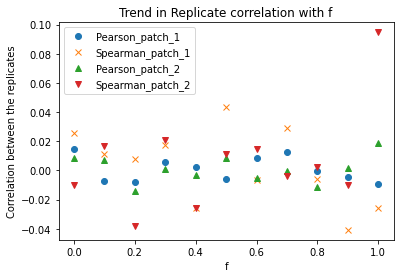

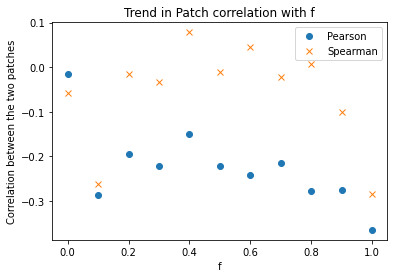

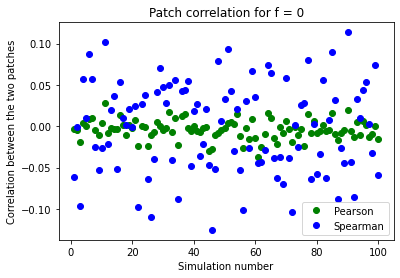

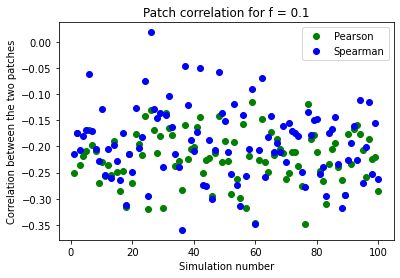

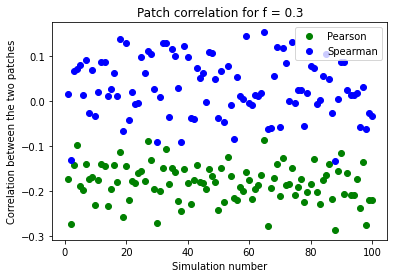

In [ ]:
## Trend in Patch correlation with f
## repeat the whole simulation 100 times for each value of f. For f = 0 (CM), f = 0.1 (LMM), f = 0.3 (HMM); store the Pearson correlation and Spearman correlation between the two patches for each of the 100 simulations  

f_arr = np.arange(0,1.1,0.1)
simulations = 100
corr_sim_arr = np.zeros([6,simulations]) # row 1 : f = 0 Pearson correlation; row 2 : f = 0 Spearman correlation; row 3 : f = 0.1 Pearson correlation; row 4 : f = 0.1 Spearman correlation; row 5 : f = 0.3 Pearson correlation; row 6 : f = 0.3 Spearman correlation
for j in range(simulations):
    corr_replicates_arr = np.zeros([4,len(f_arr)]) #first and second rows are Pearson correlation and Spearman correlation of first patch; third and fourth rows are Pearson correlation and Spearman correlation of second patch
    corr_patches_arr = np.zeros([2,len(f_arr)]) #first row is Pearson correlation and second row is Spearman correlation
    for i in range(len(f_arr)):
        f = f_arr[i]
        LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,0.1,1.49,numegg,0.1,1.49,generations,replicates)
        #transform the time series data
        transformed_LHLH_nadult_matrix1 = log_diff(LHLH_nadult_matrix1)
        transformed_LHLH_nadult_matrix2 = log_diff(LHLH_nadult_matrix2)
        corr_replicates_arr[0,i] = Pearson_corr_replicates(transformed_LHLH_nadult_matrix1)
        corr_replicates_arr[1,i] = Spearman_corr_replicates(transformed_LHLH_nadult_matrix1)
        corr_replicates_arr[2,i] = Pearson_corr_replicates(transformed_LHLH_nadult_matrix2)
        corr_replicates_arr[3,i] = Spearman_corr_replicates(transformed_LHLH_nadult_matrix2)
        corr_patches_arr[0,i] = Pearson_corr_patches(transformed_LHLH_nadult_matrix1,transformed_LHLH_nadult_matrix2)
        corr_patches_arr[1,i] = Spearman_corr_patches(transformed_LHLH_nadult_matrix1 ,transformed_LHLH_nadult_matrix2 )
    corr_sim_arr[0,j] = corr_patches_arr[0,0]
    corr_sim_arr[1,j] = corr_patches_arr[1,0]
    corr_sim_arr[2,j] = corr_patches_arr[0,1]
    corr_sim_arr[3,j] = corr_patches_arr[1,1]
    corr_sim_arr[4,j] = corr_patches_arr[0,3]
    corr_sim_arr[5,j] = corr_patches_arr[1,3]



# for the 100th simulation, plotting the replicate correlation and patch correlation with f

replcate_correlation_type = ['Pearson_patch_1','Spearman_patch_1','Pearson_patch_2','Spearman_patch_2']
replicate_marker = ['o','x','^','v']

plt.figure()
for i in range(len(replcate_correlation_type)):
    plt.plot(f_arr,corr_replicates_arr[i,:],replicate_marker[i],label=replcate_correlation_type[i])
plt.legend(replcate_correlation_type,loc = 'best')
plt.xlabel('f')
plt.ylabel('Correlation between the replicates')
plt.title('Trend in Replicate correlation with f')



patch_correlation_type = ['Pearson','Spearman']
patch_marker = ['o','x']
plt.figure()
for i in range(len(patch_correlation_type)):
    plt.plot(f_arr,corr_patches_arr[i,:],patch_marker[i],label=patch_correlation_type[i])
plt.legend(patch_correlation_type,loc = 'best')
plt.xlabel('f')
plt.ylabel('Correlation between the two patches')
plt.title('Trend in Patch correlation with f')

# plotting the patch correlation for f = 0, f = 0.1 and f = 0.3 vs simulation number
selected_f_arr = [0,0.1,0.3]
for i in range(len(selected_f_arr)):
    plt.figure()
    plt.plot(range(1,simulations+1),corr_sim_arr[2*i,:],'go',label='Pearson')
    plt.plot(range(1,simulations+1),corr_sim_arr[2*i+1,:],'bo',label='Spearman')
    plt.xlabel('Simulation number')
    plt.ylabel('Correlation between the two patches')
    plt.title(f'Patch correlation for f = {selected_f_arr[i]}')
    plt.legend(loc='best')

Text(0.5, 1.0, 'Mean and Std Dev of Spearman correlation between the two patches')

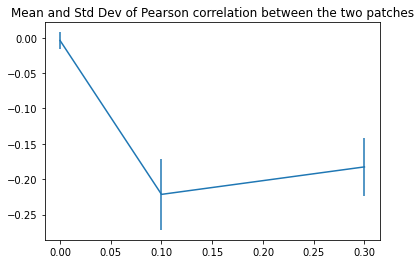

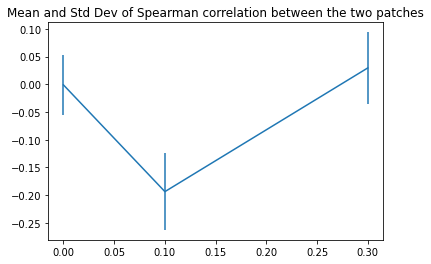

In [ ]:
selected_f_arr = [0,0.1,0.3]
markers = ['^','o','p']
labels = ['f = 0','f = 0.1','f = 0.3']


corr_mean_Pearson = np.array([np.mean(corr_sim_arr[0,:]),np.mean(corr_sim_arr[2,:]),np.mean(corr_sim_arr[4,:])])
corr_mean_Spearman = np.array([np.mean(corr_sim_arr[1,:]),np.mean(corr_sim_arr[3,:]),np.mean(corr_sim_arr[5,:])])
corr_std_Pearson = np.array([np.std(corr_sim_arr[0,:]),np.std(corr_sim_arr[2,:]),np.std(corr_sim_arr[4,:])])
corr_std_Spearman = np.array([np.std(corr_sim_arr[1,:]),np.std(corr_sim_arr[3,:]),np.std(corr_sim_arr[5,:])])

plt.figure()
plt.errorbar(selected_f_arr,corr_mean_Pearson,corr_std_Pearson)
plt.title('Mean and Std Dev of Pearson correlation between the two patches')
plt.figure()
plt.errorbar(selected_f_arr,corr_mean_Spearman,corr_std_Spearman)
plt.title('Mean and Std Dev of Spearman correlation between the two patches')

Text(0.5, 1.0, 'LHLH population')

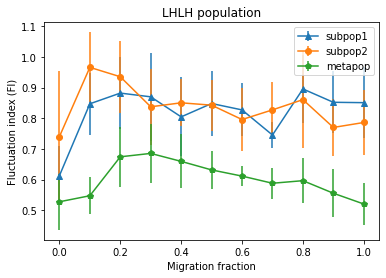

In [ ]:
## Investigating the effect of migration rate on the metapopulation stability (FI)
# will vary f from 0 to 1 in steps of 0.1
f_arr = np.arange(0,1.1,0.1)
FI_mean_arr = np.zeros([3,len(f_arr)]) # 1st row for patch 1, 2nd row for patch 2 and 3rd row for metapopulation
FI_std_arr = np.zeros([3,len(f_arr)]) 
for i in range(len(f_arr)):
    f = f_arr[i]
    LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,0.1,1.49,numegg,0.1,1.49,generations,replicates)
    LHLH_metapop_nadult_matrix,LHLH_metapop_extinctions_matrix = Metapop_matrices(LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2)
    FI_mean_arr[0,i],FI_std_arr[0,i] = FI_numadult_matrix(LHLH_nadult_matrix1)
    FI_mean_arr[1,i],FI_std_arr[1,i] = FI_numadult_matrix(LHLH_nadult_matrix2)
    FI_mean_arr[2,i],FI_std_arr[2,i] = FI_numadult_matrix(LHLH_metapop_nadult_matrix)
populations = ['subpop1', 'subpop2', 'metapop']
markers = ['^','o','p']
plt.figure()
for i in range(len(populations)):
    plt.errorbar(f_arr,FI_mean_arr[i,:],FI_std_arr[i,:],marker=markers[i],label=populations[i])
plt.legend(populations)
plt.xlabel('Migration fraction')
plt.ylabel('Fluctuation index (FI)')
plt.title('LHLH population')

Text(0.5, 1.0, 'LHLH population')

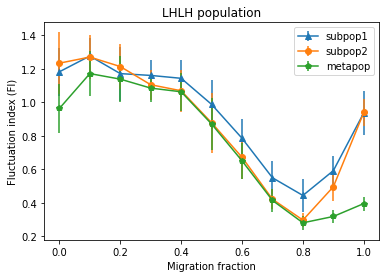

In [ ]:
## Investigating the effect of migration rate on the metapopulation stability (FI)
# will vary f from 0 to 1 in steps of 0.1
f_arr = np.arange(0,1.1,0.1)
FI_mean_arr = np.zeros([3,len(f_arr)]) # 1st row for patch 1, 2nd row for patch 2 and 3rd row for metapopulation
FI_std_arr = np.zeros([3,len(f_arr)]) 
for i in range(len(f_arr)):
    f = f_arr[i]
    LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,1.76,1.49,numegg,1.76,1.49,generations,replicates)
    LHLH_metapop_nadult_matrix,LHLH_metapop_extinctions_matrix = Metapop_matrices(LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2)
    FI_mean_arr[0,i],FI_std_arr[0,i] = FI_numadult_matrix(LHLH_nadult_matrix1)
    FI_mean_arr[1,i],FI_std_arr[1,i] = FI_numadult_matrix(LHLH_nadult_matrix2)
    FI_mean_arr[2,i],FI_std_arr[2,i] = FI_numadult_matrix(LHLH_metapop_nadult_matrix)
populations = ['subpop1', 'subpop2', 'metapop']
markers = ['^','o','p']
plt.figure()
for i in range(len(populations)):
    plt.errorbar(f_arr,FI_mean_arr[i,:],FI_std_arr[i,:],marker=markers[i],label=populations[i])
plt.legend(populations)
plt.xlabel('Migration fraction')
plt.ylabel('Fluctuation index (FI)')
plt.title('LHLH population')

In [ ]:
## do 100 simulations and get an average of the FI for f = 0, f = 0.1 and f = 0.3

In [ ]:
## Investigating the effect of migration rate on the metapopulation persistence (extinction frequency)
# will vary f from 0 to 1 in steps of 0.1
f_arr = np.arange(0,1.1,0.1)
extinc_freq_mean_arr = np.zeros([3,len(f_arr)]) # 1st row for patch 1, 2nd row for patch 2 and 3rd row for metapopulation
extinc_freq_std_arr = np.zeros([3,len(f_arr)])
for i in range(len(f_arr)):
    f = f_arr[i]
    #print(f)
    LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,0.1,1.49,numegg,0.1,1.49,generations,replicates)
    LHLH_metapop_nadult_matrix,LHLH_metapop_extinctions_matrix = Metapop_matrices(LHLH_nadult_matrix1,LHLH_extinctions_matrix1,LHLH_nadult_matrix2,LHLH_extinctions_matrix2)
    extinc_freq_mean_arr[0,i],extinc_freq_std_arr[0,i],extinc_freq_mean_arr[1,i],extinc_freq_std_arr[1,i]  = Extinction_freq(LHLH_extinctions_matrix1,LHLH_extinctions_matrix2)
    #print(extinc_freq_mean_arr[0,i],extinc_freq_mean_arr[1,i])
    extinc_freq_mean_arr[2,i],extinc_freq_std_arr[2,i] = metapop_extinc_freq(LHLH_metapop_extinctions_matrix)
    #print(extinc_freq_mean_arr[2,i])
populations = ['subpop1', 'subpop2', 'metapop']
markers = ['^','o','p']
plt.figure()
for i in range(len(populations)):
    plt.errorbar(f_arr,extinc_freq_mean_arr[i,:],extinc_freq_std_arr[i,:],marker=markers[i],label=populations[i])
plt.legend(populations)
plt.xlabel('Migration fraction')
plt.ylabel('Extinction frequency')
plt.title('LHLH population')
    

### Experimental Data

In [30]:
migration_15_data = pd.read_excel("LHLH_data.xls",sheet_name="15_percent_migration")
migration_15_nadult_matrix1, migration_15_nadult_matrix2, migration_15_metapop_nadult_matrix, migration_15_extinctions_matrix1, migration_15_extinctions_matrix2, migration_15_metapop_extinctions_matrix = patch_data(migration_15_data)
migration_15_metapop_nadult_matrix = Metapop_numadult_matrix(migration_15_nadult_matrix1,migration_15_nadult_matrix2)

In [31]:
migration_45_data = pd.read_excel("LHLH_data.xls",sheet_name="45_percent_migration")
migration_45_nadult_matrix1, migration_45_nadult_matrix2, migration_45_metapop_nadult_matrix, migration_45_extinctions_matrix1, migration_45_extinctions_matrix2, migration_45_metapop_extinctions_matrix = patch_data(migration_45_data)
migration_45_metapop_nadult_matrix = Metapop_numadult_matrix(migration_45_nadult_matrix1,migration_45_nadult_matrix2)

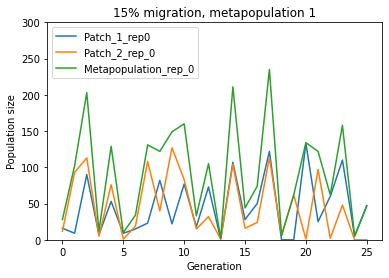

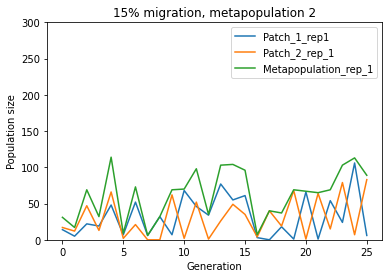

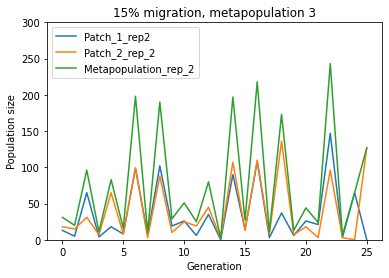

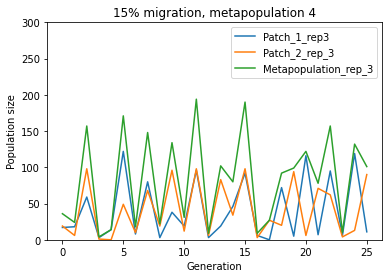

In [30]:
# plotting the time series for 15% migration

for i in range(4):
    plt.title(f"15% migration, metapopulation {i+1}")
    plt.ylim(0,300)
    plot_time_series(migration_15_nadult_matrix1,migration_15_nadult_matrix2,migration_15_metapop_nadult_matrix,[i])

In [31]:
# correlation between the two patches for 45% migration
for i in range(4):
    corr = np.corrcoef(migration_45_nadult_matrix1[:,i],migration_45_nadult_matrix2[:,i])
    print(corr[0,1])

0.8065119871728729
0.8755385047043278
0.6911386937742713
0.857687876251896


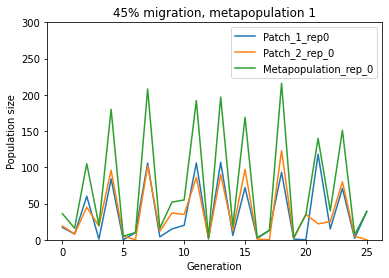

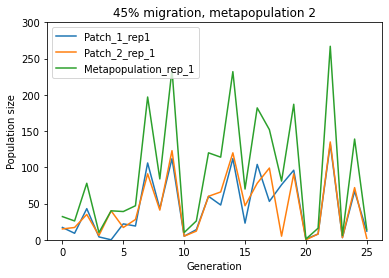

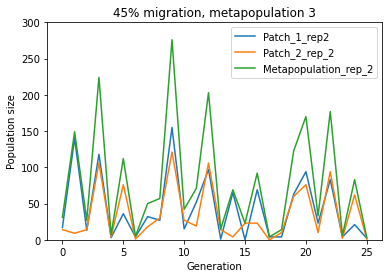

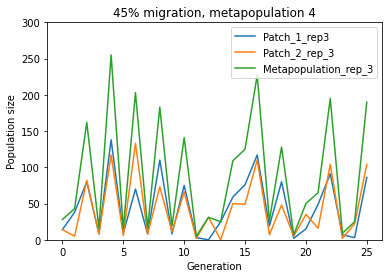

In [32]:
# plotting the time series for 45% migration

for i in range(4):
    plt.title(f"45% migration, metapopulation {i+1}")
    plt.ylim(0,300)
    plot_time_series(migration_45_nadult_matrix1,migration_45_nadult_matrix2,migration_45_metapop_nadult_matrix,[i])

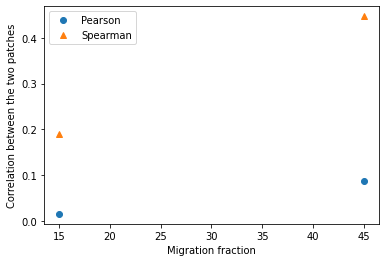

In [38]:
migration_15_nadult_matrix1, migration_15_nadult_matrix2, migration_15_metapop_nadult_matrix, migration_15_extinctions_matrix1, migration_15_extinctions_matrix2, migration_15_metapop_extinctions_matrix = patch_data(migration_15_data)
migration_45_nadult_matrix1, migration_45_nadult_matrix2, migration_45_metapop_nadult_matrix, migration_45_extinctions_matrix1, migration_45_extinctions_matrix2, migration_45_metapop_extinctions_matrix = patch_data(migration_45_data)

# comparing correlation between the two patches for 15% and 45% migration
# transform the time series data
migration_15_nadult_matrix1t = log_diff(migration_15_nadult_matrix1)
migration_15_nadult_matrix2t = log_diff(migration_15_nadult_matrix2)
migration_45_nadult_matrix1t = log_diff(migration_45_nadult_matrix1)
migration_45_nadult_matrix2t = log_diff(migration_45_nadult_matrix2)
# calculate the correlation
Pearson_corr_arr = [Pearson_corr_patches(migration_15_nadult_matrix1t,migration_15_nadult_matrix2t),Pearson_corr_patches(migration_45_nadult_matrix1t,migration_45_nadult_matrix2t)]
Spearman_corr_arr = [Spearman_corr_patches(migration_15_nadult_matrix1t,migration_15_nadult_matrix2t),Spearman_corr_patches(migration_45_nadult_matrix1t,migration_45_nadult_matrix2t)]
#Pearson_corr_arr = [Pearson_corr_patches_FT(migration_15_nadult_matrix1,migration_15_nadult_matrix2),Pearson_corr_patches_FT(migration_45_nadult_matrix1,migration_45_nadult_matrix2)]
#Spearman_corr_arr = [Spearman_corr_patches_FT(migration_15_nadult_matrix1,migration_15_nadult_matrix2),Spearman_corr_patches_FT(migration_45_nadult_matrix1,migration_45_nadult_matrix2)]
# plot the correlation
migration_arr = [15,45]
plt.figure()
plt.plot(migration_arr,Pearson_corr_arr,'o')
plt.plot(migration_arr,Spearman_corr_arr,'^')
plt.xlabel('Migration fraction') 
plt.ylabel('Correlation between the two patches')
plt.legend(['Pearson','Spearman'])
plt.show()

### Coarser range of parameters but 4-fold cross validation based on metapopulation data

In [27]:
#  4 values of food × 29 sen_adden × 10 sen_adsize × 7 adnut =  8,120 combinations
# the number of individual parameters (low like 8 or high like 58) has been decided based on the importance of the parameter in affecting the dynamics
food_arr = np.arange(1.16,2.76,0.4) # 4 values
sen_adden_arr = np.arange(0.01,0.59,0.02) # 29 values
sen_adsize_arr = np.arange(0.2,2.2,0.2) # 10 values
adnut_arr = np.arange(1.07,2.05,0.14) # 7 values


In [96]:
f = 0
np.random.seed(0)
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
print(LHLH_metapop_nadult_matrix[:,0])

[ 34.  54.  80.  25. 207.  23.  31. 104. 184.  18.  10.  32.  10. 129.
  24.  10.  28.  16. 184.  31.  81.  28. 253.  23. 321.  36.]


In [97]:
f = 0.45
np.random.seed(0)
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
print(LHLH_metapop_nadult_matrix[:,0])

[ 34.  57.  21. 188.  27.  81.  27. 176.  36.  64.  27. 151.  15. 352.
  37. 219.  27.  76.  25. 193.  27. 136.  26. 101.  30.  28.]


### plot cost_function as a function of one parameter (keep the other parameters constant)

In [ ]:
# cost function will be between patch 1 and 2 of exp metapop 1,2 and 3 and 50 replicates of sim patch 1 and 2

Text(0, 0.5, 'cost function')

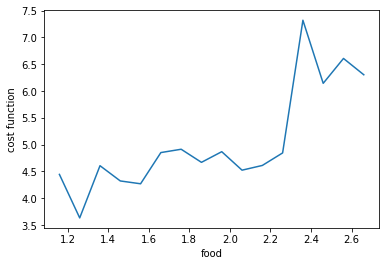

In [42]:
# vary food from 1.16 to 2.76 in steps of 0.1
# sen_adden = 0.17
# sen_adsize = 1.7
# adnut = 1.49 (constant values from the 2019 paper)

food_arr = np.arange(1.16,2.76,0.1)
sen_adden = 0.17
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 50
numegg = 18
cost_funcn_arr = np.zeros([len(food_arr),1]) 
for i in range(len(food_arr)):
    food = food_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    #cost_funcn_arr[i] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,np.arange(2)],migration_45_nadult_matrix2[:,np.arange(2)]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))
    cost_funcn_arr[i] = cost_function(migration_45_nadult_matrix1[:,np.arange(3)],LHLH_numadult_matrix1) + cost_function(migration_45_nadult_matrix2[:,np.arange(3)],LHLH_numadult_matrix2)
plt.plot(food_arr,cost_funcn_arr)
plt.xlabel("food")
plt.ylabel("cost function")

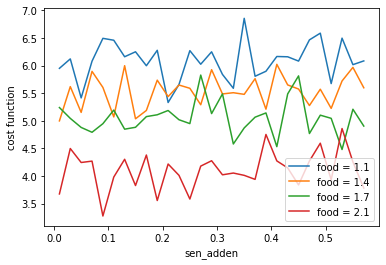

In [43]:
# the cost kind of increases with food but not very clearly, 
# food_arr = [1.1,1.4,1.7,2.1] 

# vary sen_adden from 0.01 to 0.59 in steps of 0.02
# sen_adsize = 1.7
# adnut = 1.49 


sen_adden_arr = np.arange(0.01,0.59,0.02)
food_arr = [1.1,1.4,1.7,2.1] 
sen_adsize = 1.7
adnut = 2.05
f = 0.45
generations = 26
replicates = 50
numegg = 18
cost_funcn_arr = np.zeros([4,len(sen_adden_arr)])  

for i in range(len(food_arr)):
        food = food_arr[i]
        for j in range(len(sen_adden_arr)):

                LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
                #cost_funcn_arr[i][j] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,np.arange(2)],migration_45_nadult_matrix2[:,np.arange(2)]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))
                cost_funcn_arr[i][j] = cost_function(migration_45_nadult_matrix1[:,np.arange(3)],LHLH_numadult_matrix1) + cost_function(migration_45_nadult_matrix2[:,np.arange(3)],LHLH_numadult_matrix2)
for i in range(len(food_arr)):
    plt.plot(sen_adden_arr,cost_funcn_arr[i,:],label=f"food = {food_arr[i]}")
    plt.xlabel("sen_adden")
    plt.ylabel("cost function")
plt.legend()
plt.show()

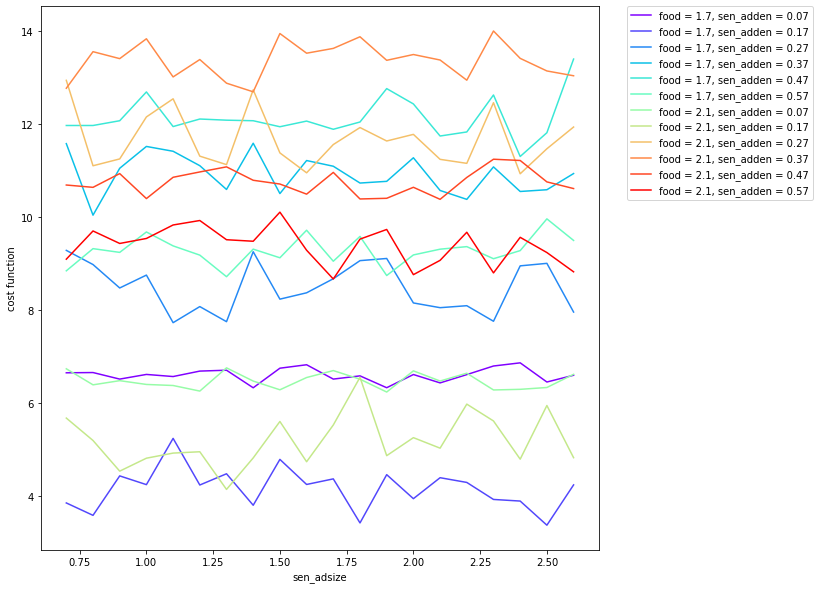

In [44]:
# vary sen_adsize from 0.7 to 2.7 in steps of 0.1 
# food_arr = [1.7,2.1]
# sen_adden_arr = [0.07,0.17,0.27,0.37,0.47,0.57]
# adnut = 1.49

sen_adsize_arr = np.arange(0.7,2.7,0.1)
food_arr = [1.7,2.1]
sen_adden_arr = [0.07,0.17,0.27,0.37,0.47,0.57]
adnut = 1.49
f = 0.45
generations = 26
replicates = 50
numegg = 18
combn = list(it.product(food_arr,sen_adden_arr))
cost_funcn_arr = np.zeros([len(combn),len(sen_adsize_arr)]) 
for i in range(len(combn)):
    food,sen_adden = combn[i]

    for j in range(len(sen_adsize_arr)):

        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        #cost_funcn_arr[i][j] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,np.arange(2)],migration_45_nadult_matrix2[:,np.arange(2)]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))
        cost_funcn_arr[i][j] = cost_function(migration_45_nadult_matrix1[:,np.arange(3)],LHLH_numadult_matrix1) + cost_function(migration_45_nadult_matrix2[:,np.arange(3)],LHLH_numadult_matrix2)
plt.figure(figsize=(10,10))
color = iter(plt.cm.rainbow(np.linspace(0,1,len(combn))))
for i in range(len(combn)):
    c = next(color)
    plt.plot(sen_adsize_arr,cost_funcn_arr[i,:],label=f"food = {combn[i][0]}, sen_adden = {combn[i][1]}",c=c)
    plt.xlabel("sen_adsize")
    plt.ylabel("cost function")
# legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

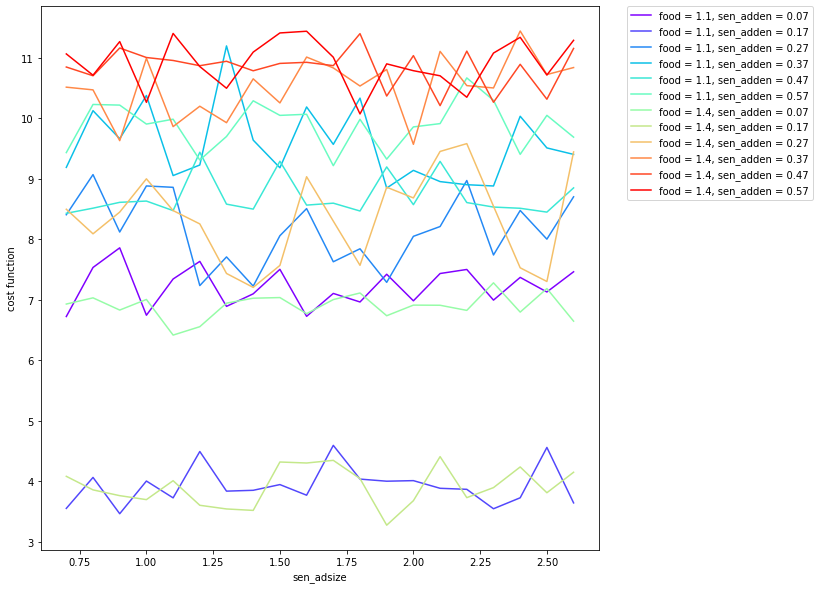

In [45]:
# vary sen_adsize from 0.7 to 2.7 in steps of 0.1 
# food_arr = [1.7,2.1] from the previous plot but with food = 1.1 or 1.4, we get just as good results 
# sen_adden_arr = [0.07,0.17,0.27,0.37,0.47,0.57]
# adnut = 1.49

sen_adsize_arr = np.arange(0.7,2.7,0.1)
food_arr = [1.1,1.4]
sen_adden_arr = [0.07,0.17,0.27,0.37,0.47,0.57]
adnut = 1.49
f = 0.45
generations = 26
replicates = 50
numegg = 18
combn = list(it.product(food_arr,sen_adden_arr))
cost_funcn_arr = np.zeros([len(combn),len(sen_adsize_arr)]) 
for i in range(len(combn)):
    food,sen_adden = combn[i]

    for j in range(len(sen_adsize_arr)):

        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        #cost_funcn_arr[i][j] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,np.arange(2)],migration_45_nadult_matrix2[:,np.arange(2)]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))
        cost_funcn_arr[i][j] = cost_function(migration_45_nadult_matrix1[:,np.arange(3)],LHLH_numadult_matrix1) + cost_function(migration_45_nadult_matrix2[:,np.arange(3)],LHLH_numadult_matrix2)
plt.figure(figsize=(10,10))
color = iter(plt.cm.rainbow(np.linspace(0,1,len(combn))))
for i in range(len(combn)):
    c = next(color)
    plt.plot(sen_adsize_arr,cost_funcn_arr[i,:],label=f"food = {combn[i][0]}, sen_adden = {combn[i][1]}",c=c)
    plt.xlabel("sen_adsize")
    plt.ylabel("cost function")
# legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [47]:
# vary adnut from 1.07 to 2.05 in steps of 0.03
# food_arr = [1.1,1.4,1.7,2.1] 
# sen_adden = 0.17
# sen_adsize = [0.75,1,1.25,1.5,1.75,2.0,2.25,2.50]

adnut_arr = np.arange(1.07,2.05,0.01)
food_arr = [1.1,1.4,1.7,2.1]
sen_adden = 0.17
sen_adsize_arr = np.arange(0.75,2.75,0.25)
f = 0.45
generations = 26
replicates = 50
numegg = 18
combn = list(it.product(food_arr,sen_adsize_arr))
cost_funcn_arr = np.zeros([len(combn),len(adnut_arr)])
for i in range(len(combn)):
    food,sen_adsize = combn[i]

    for j in range(len(adnut_arr)):

        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        cost_funcn_arr[i][j] = cost_function(migration_45_nadult_matrix1[:,np.arange(3)],LHLH_numadult_matrix1) + cost_function(migration_45_nadult_matrix2[:,np.arange(3)],LHLH_numadult_matrix2)
#plt.figure(figsize=(10,10))





In [ ]:
#color = iter(plt.cm.rainbow(np.linspace(0,1,len(combn))))
# for each combination of food and sen_adsize, plot the cost function vs adnut. use subplot
# 4 rows, 4 columns 16 plots
#plt.figure(figsize=(15,15))
for i in range(len(combn)):
    #c = next(color)
    #plt.subplot(4,8,i+1)
    plt.figure()
    plt.plot(adnut_arr,cost_funcn_arr[i,:])
    plt.xlabel("adnut")
    plt.ylabel("cost function")
    plt.title(f"f = {combn[i][0]}, s_s = {combn[i][1]}")
    plt.ylim(0,10)
    plt.xlim(1.07,2.05)
    plt.show()
# legend outside the plot
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.suptitle("cost function vs adnut",fontsize=20)

Text(0, 0.5, 'cost function')

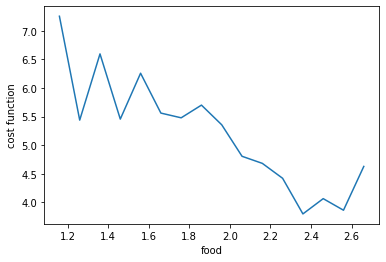

In [51]:
# but the above procedure doesn't tell us much beacause 
# for eg. if we set the adnut value to 2.05, then the minima occurs at a much higher value of food

# vary food from 1.16 to 2.76 in steps of 0.1
# sen_adden = 0.17
# sen_adsize = 1.7
# adnut =

food_arr = np.arange(1.16,2.76,0.1)
sen_adden = 0.17
sen_adsize = 2
adnut = 2.05
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([len(food_arr),1]) 
for i in range(len(food_arr)):
    food = food_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    cost_funcn_arr[i] = cost_function(migration_45_nadult_matrix1[:,np.arange(3)],LHLH_numadult_matrix1) + cost_function(migration_45_nadult_matrix2[:,np.arange(3)],LHLH_numadult_matrix2)
plt.plot(food_arr,cost_funcn_arr)
plt.xlabel("food")
plt.ylabel("cost function")

In [57]:

#  8 values of food × 58 sen_adden × 20 sen_adsize × 14 adnut = 129,920 combinations
# the number of individual parameters (low like 8 or high like 58) has been decided based on the importance of the parameter in affecting the dynamics
food_arr = np.arange(1.16,2.76,0.2) # 8 values
sen_adden_arr = np.arange(0.01,1.16,0.02) # 58 values
sen_adsize_arr = np.arange(0.2,4.2,0.2) # 20 values
adnut_arr = np.arange(1.15,3.20,0.15) # 14 values

combinations = list(it.product(food_arr,sen_adden_arr,sen_adsize_arr,adnut_arr))
# for each combination, do 50 simulations and calculate the cost function. 
# store the combination and the cost function in a 2D array
f = 0.45
numegg = 18
generations = 26
replicates = 50

combn_cost_funcn_arr = np.zeros([len(combinations),5]) # 1st column is food, 2nd column is sen_adden, 3rd column is sen_adsize, 4th column is adnut, 5th column is cost function
for i in range(len(combinations)):
    food = combinations[i][0]
    sen_adden = combinations[i][1]
    sen_adsize = combinations[i][2]
    adnut = combinations[i][3]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    combn_cost_funcn_arr[i,0] = food
    combn_cost_funcn_arr[i,1] = sen_adden
    combn_cost_funcn_arr[i,2] = sen_adsize
    combn_cost_funcn_arr[i,3] = adnut
    combn_cost_funcn_arr[i,4] =  cost_function(migration_45_nadult_matrix1[:,np.arange(3)],LHLH_numadult_matrix1) + cost_function(migration_45_nadult_matrix2[:,np.arange(3)],LHLH_numadult_matrix2)
# store the cost function array in a csv file
np.savetxt(f"cost_function_array_patch_data_rep_123.csv",combn_cost_funcn_arr,delimiter=",")
# trained on patch data of replicates 1,2,3 


In [30]:
# read the cost function array from the csv file
# find the combination with the lowest cost function
combn_cost_funcn_arr = np.loadtxt(f"cost_function_array_patch_data_rep_123.csv",delimiter=",")
min_cost_index = np.argmin(combn_cost_funcn_arr[:,4])
optimum_params = combn_cost_funcn_arr[min_cost_index,0:4]
print(optimum_params)

[2.16 0.07 1.4  1.15]


Patch 1


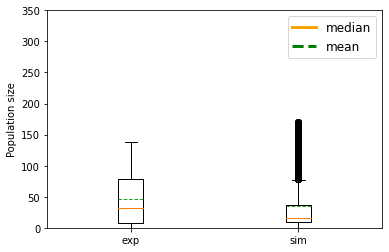

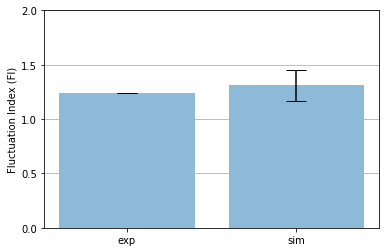

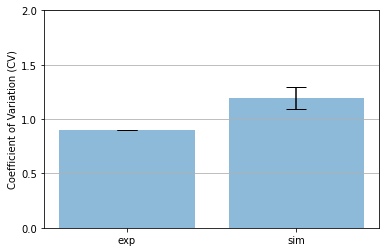

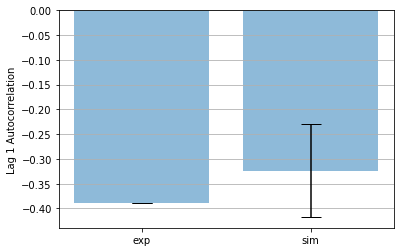

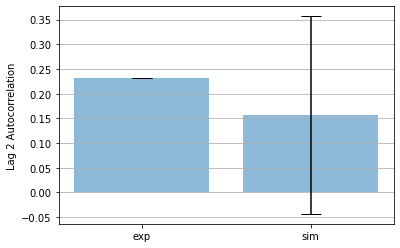

Patch 2


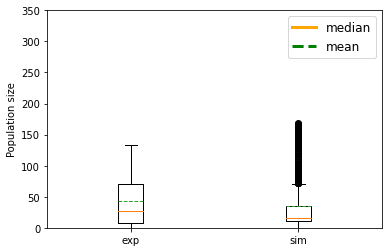

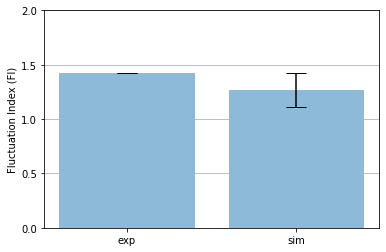

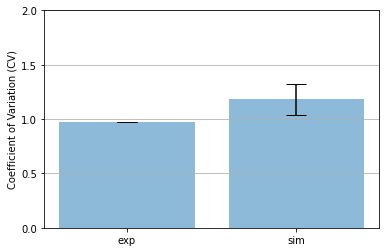

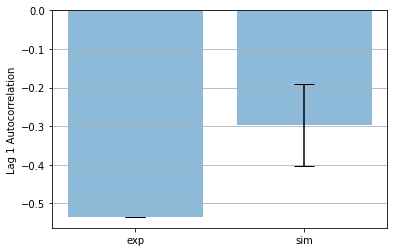

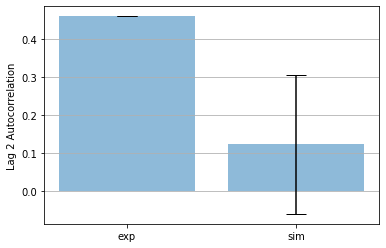

Metapopulation


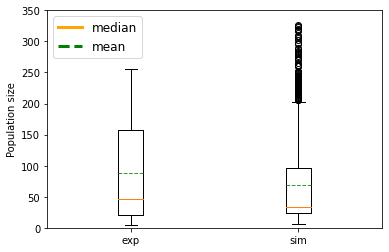

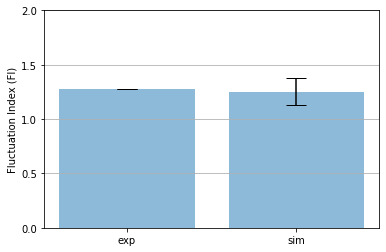

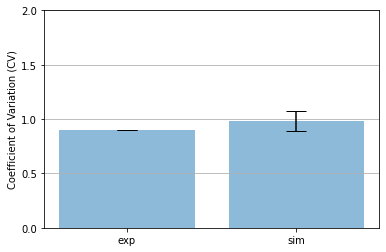

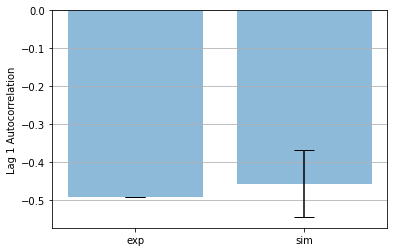

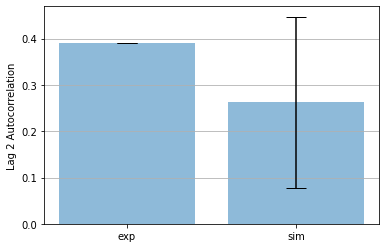

In [31]:
# plot the distributions of characters for patch 1,2 as well as the metapopulation of rep 4
# for the optimum parameters
food = optimum_params[0]
sen_adden = optimum_params[1]
sen_adsize = optimum_params[2]
adnut = optimum_params[3]
f = 0.45
generations = 26
replicates = 50
numegg = 18
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
print("Patch 1")
plot_validation(migration_45_nadult_matrix1[:,3],LHLH_numadult_matrix1)
print("Patch 2")
plot_validation(migration_45_nadult_matrix2[:,3],LHLH_numadult_matrix2)
print("Metapopulation")
plot_validation(migration_45_metapop_nadult_matrix[:,3],LHLH_metapop_nadult_matrix)

In [32]:
# check if the synchrony between the patches is captured
# experimental data
rep4 = Pearson_corr_patches(migration_45_nadult_matrix1[:,3],migration_45_nadult_matrix2[:,3])
print("For the 4th replicate of the experimental data, the Pearson correlation between the two patches is",rep4)
rep_1_to_3 = Pearson_corr_patches(migration_45_nadult_matrix1[:,np.arange(3)],migration_45_nadult_matrix2[:,np.arange(3)])
print("For the 1st to 3rd replicate of the experimental data, the avg Pearson correlation between the two patches is",rep_1_to_3)
rep_1_to_4 = Pearson_corr_patches(migration_45_nadult_matrix1[:,np.arange(4)],migration_45_nadult_matrix2[:,np.arange(4)])
print("For the 1st to 3rd replicate of the experimental data, the avg Pearson correlation between the two patches is",rep_1_to_4)

# simulated data
sim = Pearson_corr_patches(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
print("For the simulated data, the Pearson correlation between the two patches is",sim)


For the 4th replicate of the experimental data, the Pearson correlation between the two patches is 0.857687876251896
For the 1st to 3rd replicate of the experimental data, the avg Pearson correlation between the two patches is 0.791063061883824
For the 1st to 3rd replicate of the experimental data, the avg Pearson correlation between the two patches is 0.807719265475842
For the simulated data, the Pearson correlation between the two patches is 0.36721070259447286


In [33]:
# check if the synchrony between the patches is captured (lag 0 difference of log transformed data)
# experimental data
rep4 = Pearson_corr_patches(log_diff(migration_45_nadult_matrix1[:,3]),log_diff(migration_45_nadult_matrix2[:,3]))
print("For the 4th replicate of the experimental data, the Pearson correlation between the two patches is",rep4)
rep_1_to_3 = Pearson_corr_patches(log_diff(migration_45_nadult_matrix1[:,np.arange(3)]),log_diff(migration_45_nadult_matrix2[:,np.arange(3)]))
print("For the 1st to 3rd replicate of the experimental data, the avg Pearson correlation between the two patches is",rep_1_to_3)
rep_1_to_4 = Pearson_corr_patches(log_diff(migration_45_nadult_matrix1[:,np.arange(4)]),log_diff(migration_45_nadult_matrix2[:,np.arange(4)]))
print("For the 1st to 4th replicate of the experimental data, the avg Pearson correlation between the two patches is",rep_1_to_4)

# simulated data
sim = Pearson_corr_patches(log_diff(LHLH_numadult_matrix1),log_diff(LHLH_numadult_matrix2))
print("For the simulated data, the Pearson correlation between the two patches is",sim)

For the 4th replicate of the experimental data, the Pearson correlation between the two patches is -0.19447433026623748
For the 1st to 3rd replicate of the experimental data, the avg Pearson correlation between the two patches is 0.18103732279358778
For the 1st to 4th replicate of the experimental data, the avg Pearson correlation between the two patches is 0.08715940952863147
For the simulated data, the Pearson correlation between the two patches is 0.2704381693790708


In [61]:
np.array([[1,2,3],[4,5,6]]).flatten()

array([1, 2, 3, 4, 5, 6])

In [42]:
## use KS 2 sample test to check if the adult number distributions of the experimental data and the simulated data are the same

## patch 1
# only the 4th rep
exp_data = migration_45_nadult_matrix1[:,3]
sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 1 (only test data i.e. rep 4) \n",stats.ks_2samp(exp_data,sim_data))
# all the 4 reps
exp_data = migration_45_nadult_matrix1.flatten()
#sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 1 (all the 4 reps) \n",stats.ks_2samp(exp_data,sim_data))

## patch 2
# only the 4th rep
exp_data = migration_45_nadult_matrix2[:,3]
sim_data = LHLH_numadult_matrix2.flatten()
print("Patch 2 (only test data i.e. rep 4) \n",stats.ks_2samp(exp_data,sim_data))
# all the 4 reps
exp_data = migration_45_nadult_matrix2.flatten()
#sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 2 (all the 4 reps) \n",stats.ks_2samp(exp_data,sim_data))

## metapopulation
# only the 4th rep
exp_data = migration_45_metapop_nadult_matrix[:,3]
sim_data = LHLH_metapop_nadult_matrix.flatten()
print("Metapopulation (only test data i.e. rep 4) \n",stats.ks_2samp(exp_data,sim_data))

# all the 4 reps
exp_data = migration_45_metapop_nadult_matrix.flatten()
print("Metapopulation (all the 4 reps) \n",stats.ks_2samp(exp_data,sim_data))

Patch 1 (only test data i.e. rep 4) 
 KstestResult(statistic=0.2553846153846154, pvalue=0.059810199925950325)
Patch 1 (all the 4 reps) 
 KstestResult(statistic=0.1976923076923077, pvalue=0.0009068711805422121)
Patch 2 (only test data i.e. rep 4) 
 KstestResult(statistic=0.22846153846153847, pvalue=0.11968058970477256)
Patch 2 (all the 4 reps) 
 KstestResult(statistic=0.19615384615384615, pvalue=0.001021831241611689)
Metapopulation (only test data i.e. rep 4) 
 KstestResult(statistic=0.1976923076923077, pvalue=0.23987029375055552)
Metapopulation (all the 4 reps) 
 KstestResult(statistic=0.18846153846153846, pvalue=0.0018294859355678505)


### train on half the length of the time series and test on the other half?

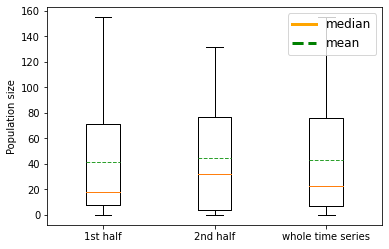

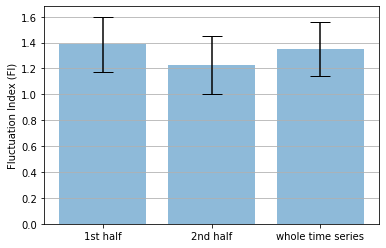

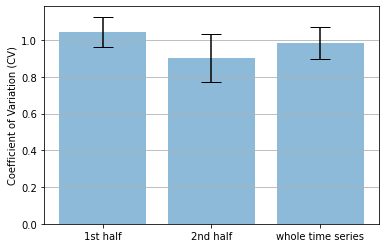

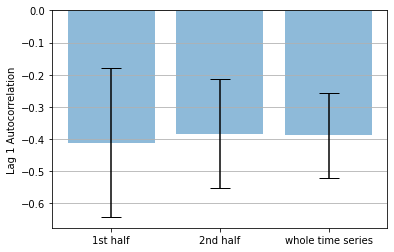

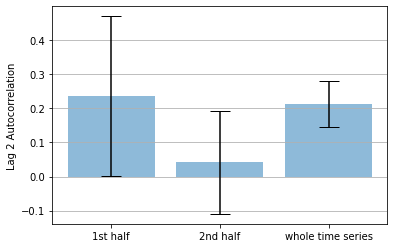

In [34]:
# plot characteristics of 1st half, 2nd half and the whole time series
half1 = np.arange(0,13)
half2 = np.arange(13,26)
# patch 1
plot_charateristics([migration_45_nadult_matrix1[half1,:],migration_45_nadult_matrix1[half2,:],migration_45_nadult_matrix1],["1st half","2nd half","whole time series"])

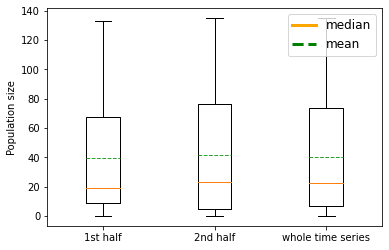

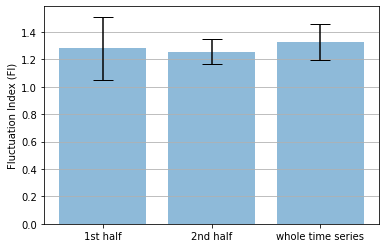

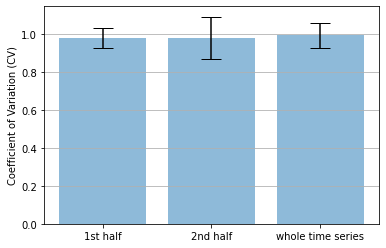

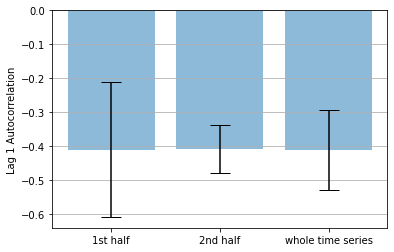

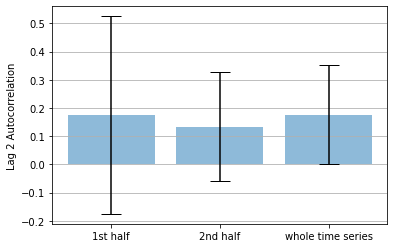

In [47]:
# patch 2
plot_charateristics([migration_45_nadult_matrix2[half1,:],migration_45_nadult_matrix2[half2,:],migration_45_nadult_matrix2],["1st half","2nd half","whole time series"])

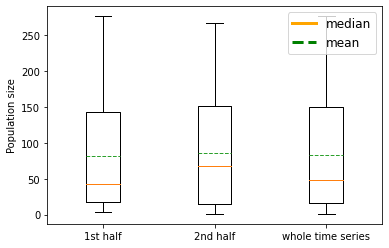

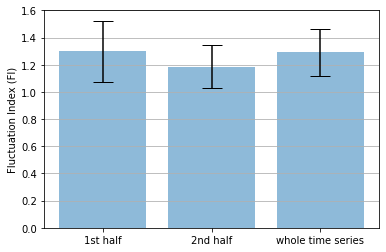

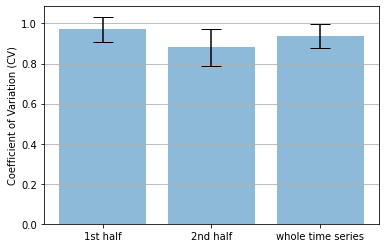

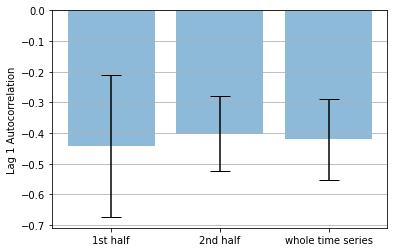

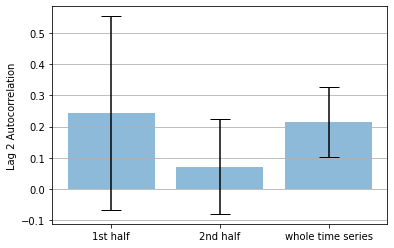

In [48]:
# metapopulation
plot_charateristics([migration_45_metapop_nadult_matrix[half1,:],migration_45_metapop_nadult_matrix[half2,:],migration_45_metapop_nadult_matrix],["1st half","2nd half","whole time series"])

In [50]:
# train on the first half 

#  8 values of food × 58 sen_adden × 20 sen_adsize × 14 adnut = 129,920 combinations
# the number of individual parameters (low like 8 or high like 58) has been decided based on the importance of the parameter in affecting the dynamics
food_arr = np.arange(1.16,2.76,0.2) # 8 values
sen_adden_arr = np.arange(0.01,1.16,0.02) # 58 values
sen_adsize_arr = np.arange(0.2,4.2,0.2) # 20 values
adnut_arr = np.arange(1.15,3.20,0.15) # 14 values

combinations = list(it.product(food_arr,sen_adden_arr,sen_adsize_arr,adnut_arr))
# for each combination, do 50 simulations and calculate the cost function. 
# store the combination and the cost function in a 2D array
f = 0.45
numegg = 18
generations = 26
replicates = 50

combn_cost_funcn_arr = np.zeros([len(combinations),5]) # 1st column is food, 2nd column is sen_adden, 3rd column is sen_adsize, 4th column is adnut, 5th column is cost function
for i in range(len(combinations)):
    food = combinations[i][0]
    sen_adden = combinations[i][1]
    sen_adsize = combinations[i][2]
    adnut = combinations[i][3]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    combn_cost_funcn_arr[i,0] = food
    combn_cost_funcn_arr[i,1] = sen_adden
    combn_cost_funcn_arr[i,2] = sen_adsize
    combn_cost_funcn_arr[i,3] = adnut
    combn_cost_funcn_arr[i,4] =  cost_function(migration_45_nadult_matrix1[half1,:],LHLH_numadult_matrix1[half1,:]) + cost_function(migration_45_nadult_matrix2[half1,:],LHLH_numadult_matrix2[half1,:])
# store the cost function array in a csv file
np.savetxt(f"cost_function_array_patch_data_half1.csv",combn_cost_funcn_arr,delimiter=",")
# trained on patch data of replicates 1,2,3 

In [39]:
# read the cost function array from the csv file
# find the combination with the lowest cost function
combn_cost_funcn_arr = np.loadtxt("cost_function_array_patch_data_half1.csv",delimiter=",")
min_cost_index = np.argmin(combn_cost_funcn_arr[:,4])
optimum_params = combn_cost_funcn_arr[min_cost_index,0:4]
print(optimum_params)

[2.36 0.07 0.4  1.6 ]


Patch 1


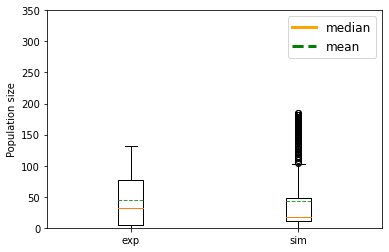

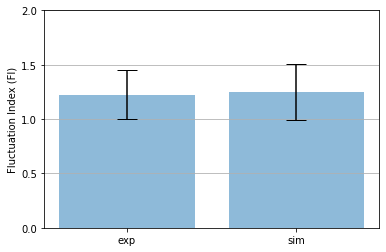

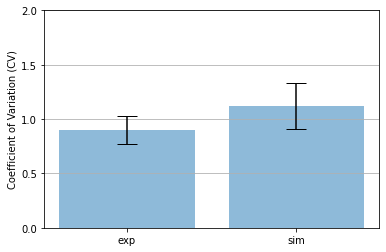

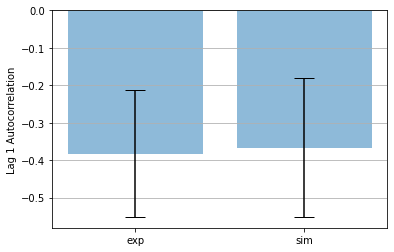

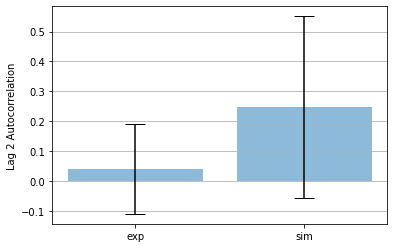

Patch 2


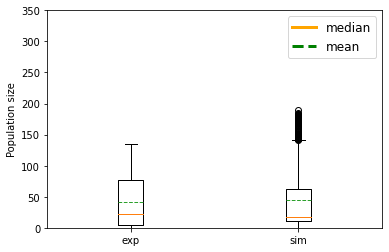

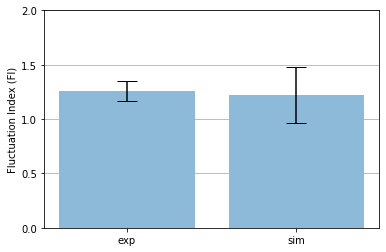

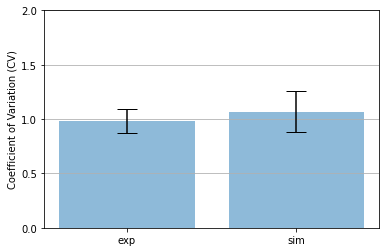

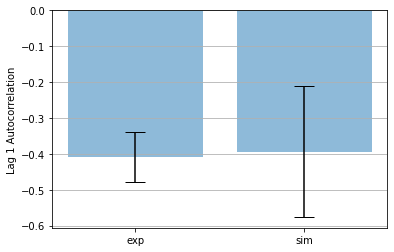

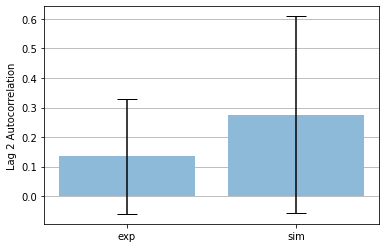

Metapopulation


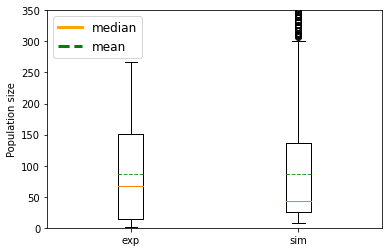

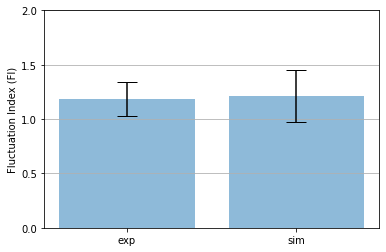

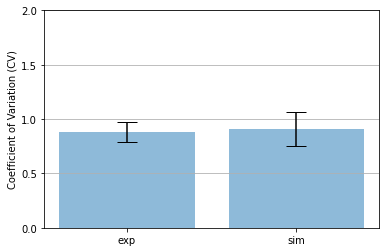

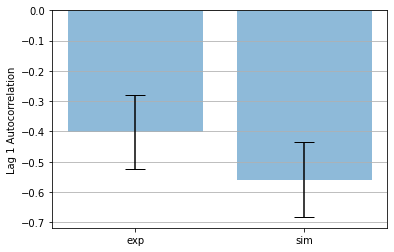

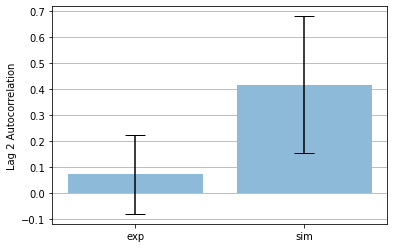

In [40]:
# check if the opt parameters can capture the dynamics of the 2nd half of the time series
food = optimum_params[0]
sen_adden = optimum_params[1]
sen_adsize = optimum_params[2]
adnut = optimum_params[3]
f = 0.45
generations = 26
replicates = 50
numegg = 18
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
print("Patch 1")
plot_validation(migration_45_nadult_matrix1[half2,:],LHLH_numadult_matrix1[half2,:])
print("Patch 2")
plot_validation(migration_45_nadult_matrix2[half2,:],LHLH_numadult_matrix2[half2,:])
print("Metapopulation")
plot_validation(migration_45_metapop_nadult_matrix[half2,:],LHLH_metapop_nadult_matrix[half2,:])

Patch 1


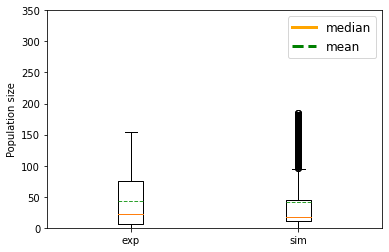

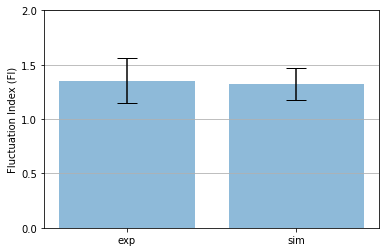

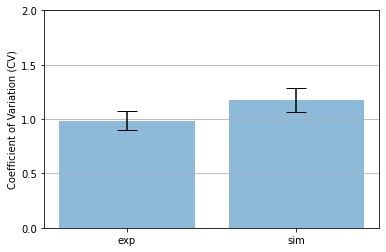

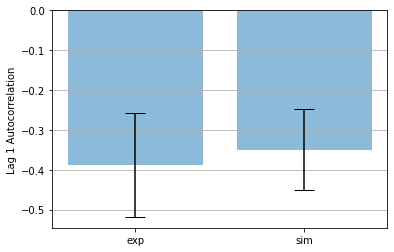

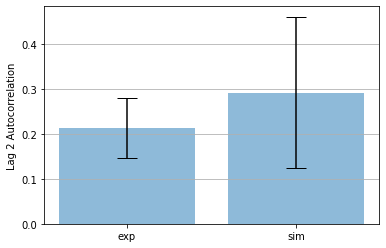

Patch 2


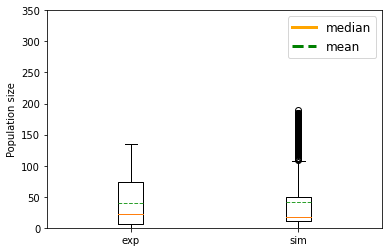

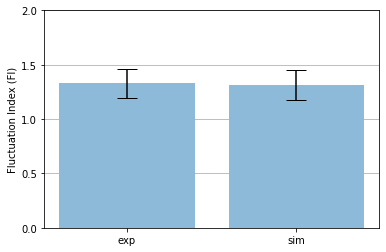

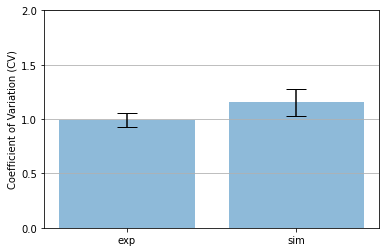

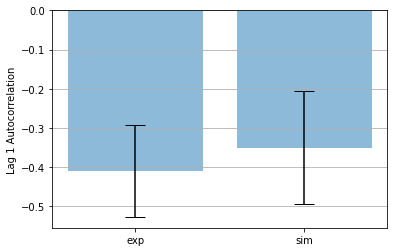

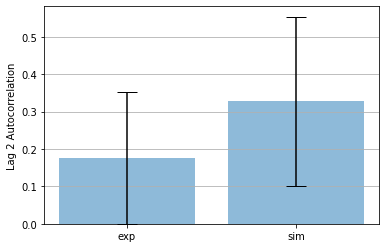

Metapopulation


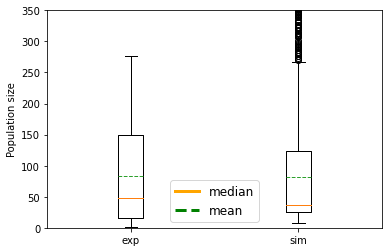

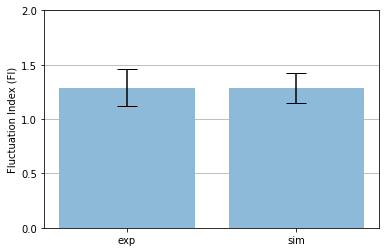

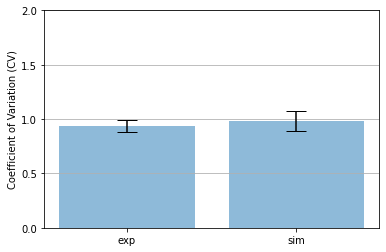

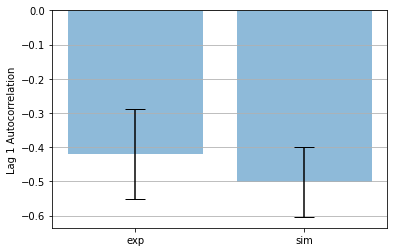

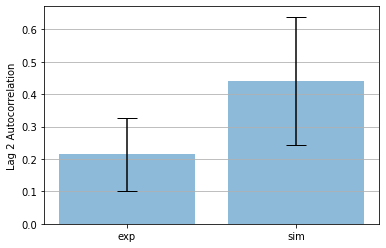

In [41]:
# whole time series
print("Patch 1")
plot_validation(migration_45_nadult_matrix1,LHLH_numadult_matrix1)
print("Patch 2")
plot_validation(migration_45_nadult_matrix2,LHLH_numadult_matrix2)
print("Metapopulation")
plot_validation(migration_45_metapop_nadult_matrix,LHLH_metapop_nadult_matrix)

In [42]:
# check if the synchrony between the patches is captured (lag 0 difference of log transformed data)
# experimental data 
exp_sync_half2 = Pearson_corr_patches(log_diff(migration_45_nadult_matrix1[half2,:]),log_diff(migration_45_nadult_matrix2[half2,:]))
print("For the 2nd half of the experimental data, the Pearson correlation between the two patches is",exp_sync_half2)

# simulated data
sim_sync_half2 = Pearson_corr_patches(log_diff(LHLH_numadult_matrix1[half2,:]),log_diff(LHLH_numadult_matrix2[half2,:]))
print("For the 2nd half of the simulated data, the Pearson correlation between the two patches is",sim_sync_half2)

# whole time series
exp_sync_whole = Pearson_corr_patches(log_diff(migration_45_nadult_matrix1),log_diff(migration_45_nadult_matrix2))
print("For the whole time series of the experimental data, the Pearson correlation between the two patches is",exp_sync_whole)

# simulated data
sim_sync_whole = Pearson_corr_patches(log_diff(LHLH_numadult_matrix1),log_diff(LHLH_numadult_matrix2))
print("For the whole time series of the simulated data, the Pearson correlation between the two patches is",sim_sync_whole)

For the 2nd half of the experimental data, the Pearson correlation between the two patches is 0.3448383549477081
For the 2nd half of the simulated data, the Pearson correlation between the two patches is 0.451683620642312
For the whole time series of the experimental data, the Pearson correlation between the two patches is 0.08715940952863147
For the whole time series of the simulated data, the Pearson correlation between the two patches is 0.39692542867031255


In [43]:
## use KS 2 sample test to check if the adult number distributions of the experimental data and the simulated data are the same

##patch 1
# 2nd half of the time series
exp_data = migration_45_nadult_matrix1[half2,:].flatten()
sim_data = LHLH_numadult_matrix1[half2,:].flatten()
print("Patch 1 (2nd half) \n",stats.ks_2samp(exp_data,sim_data))
# entire time series
exp_data = migration_45_nadult_matrix1.flatten()
sim_data = LHLH_numadult_matrix1.flatten()
#sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 1 (entire time seies) \n",stats.ks_2samp(exp_data,sim_data))

##patch 1
# 2nd half of the time series
exp_data = migration_45_nadult_matrix2[half2,:].flatten()
sim_data = LHLH_numadult_matrix2[half2,:].flatten()
print("Patch 2 (2nd half) \n",stats.ks_2samp(exp_data,sim_data))
# entire time series
exp_data = migration_45_nadult_matrix2.flatten()
sim_data = LHLH_numadult_matrix2.flatten()
#sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 2 (entire time seies) \n",stats.ks_2samp(exp_data,sim_data))

## metapopulation
# 2nd half of the time series
exp_data = migration_45_metapop_nadult_matrix[half2,:].flatten()
sim_data = LHLH_metapop_nadult_matrix[half2,:].flatten()
print("Metapopulation (2nd half) \n",stats.ks_2samp(exp_data,sim_data))

# all the 4 reps
exp_data = migration_45_metapop_nadult_matrix.flatten()
sim_data = LHLH_metapop_nadult_matrix.flatten()
print("Metapopulation (entire time series) \n",stats.ks_2samp(exp_data,sim_data))

Patch 1 (2nd half) 
 KstestResult(statistic=0.2530769230769231, pvalue=0.003368491831800769)
Patch 1 (entire time seies) 
 KstestResult(statistic=0.22076923076923077, pvalue=0.00013490113523085726)
Patch 2 (2nd half) 
 KstestResult(statistic=0.27307692307692305, pvalue=0.0011760033392501671)
Patch 2 (entire time seies) 
 KstestResult(statistic=0.20846153846153845, pvalue=0.0003828808272244196)
Metapopulation (2nd half) 
 KstestResult(statistic=0.2376923076923077, pvalue=0.007150433892598598)
Metapopulation (entire time series) 
 KstestResult(statistic=0.22846153846153847, pvalue=6.81087756493739e-05)


### train on reps 1,2 and 3 of 15% migration data

In [51]:
# read the cost function array from the csv file
# find the combination with the lowest cost function
combn_cost_funcn_arr = np.loadtxt(f"cost_function_array_patch_data_rep_123_f15.csv",delimiter=",")
min_cost_index = np.argmin(combn_cost_funcn_arr[:,4])
optimum_params = combn_cost_funcn_arr[min_cost_index,0:4]
print(optimum_params)

[2.16 0.13 0.4  2.05]


Patch 1


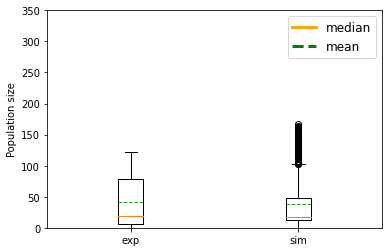

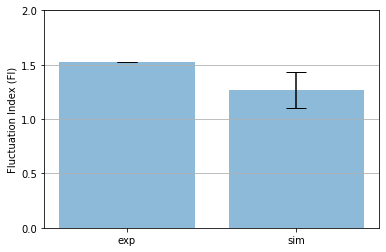

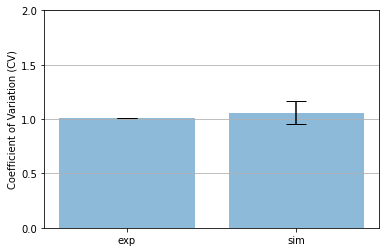

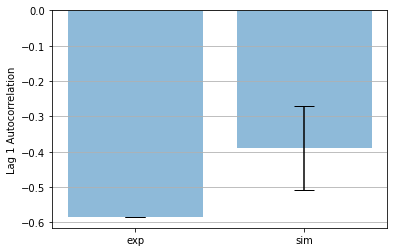

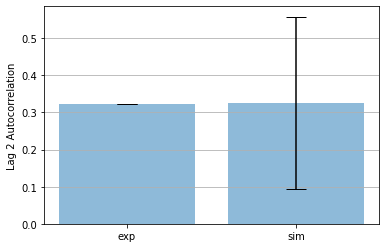

Patch 2


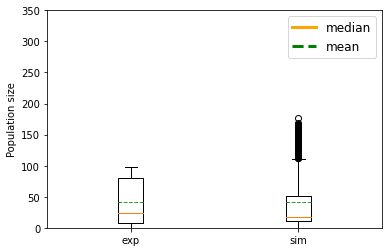

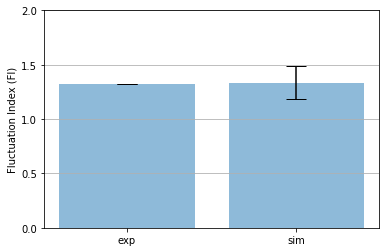

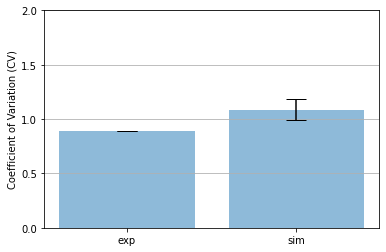

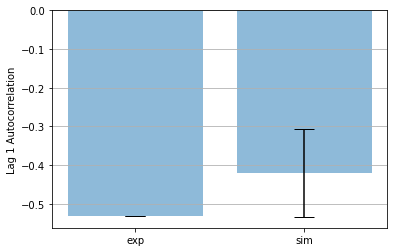

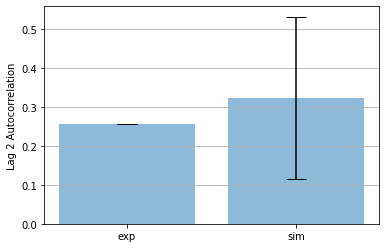

Metapopulation


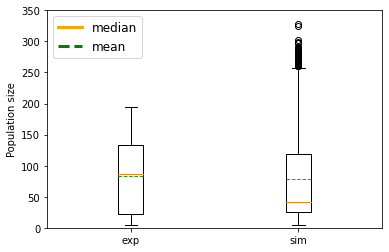

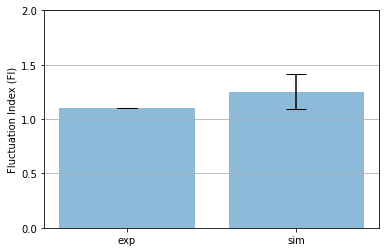

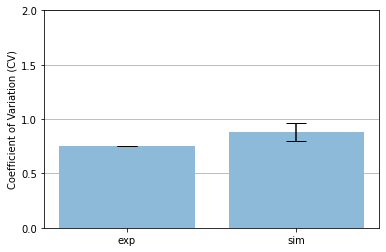

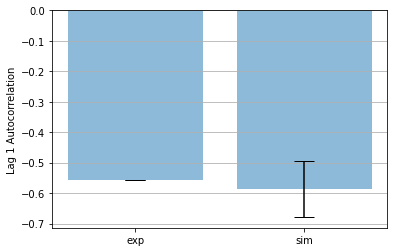

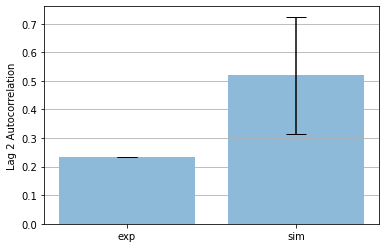

In [52]:
# plot the distributions of characters for patch 1,2 as well as the metapopulation of rep 4
# for the optimum parameters
food = optimum_params[0]
sen_adden = optimum_params[1]
sen_adsize = optimum_params[2]
adnut = optimum_params[3]
f = 0.15
generations = 26
replicates = 50
numegg = 18
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
print("Patch 1")
plot_validation(migration_15_nadult_matrix1[:,3],LHLH_numadult_matrix1)
print("Patch 2")
plot_validation(migration_15_nadult_matrix2[:,3],LHLH_numadult_matrix2)
print("Metapopulation")
plot_validation(migration_15_metapop_nadult_matrix[:,3],LHLH_metapop_nadult_matrix)

In [53]:
# check if the synchrony between the patches is captured (lag 0 difference of log transformed data)
# experimental data
rep4 = Pearson_corr_patches(log_diff(migration_15_nadult_matrix1[:,3]),log_diff(migration_15_nadult_matrix2[:,3]))
print("For the 4th replicate of the experimental data, the Pearson correlation between the two patches is",rep4)
rep_1_to_3 = Pearson_corr_patches(log_diff(migration_15_nadult_matrix1[:,np.arange(3)]),log_diff(migration_15_nadult_matrix2[:,np.arange(3)]))
print("For the 1st to 3rd replicate of the experimental data, the avg Pearson correlation between the two patches is",rep_1_to_3)
rep_1_to_4 = Pearson_corr_patches(log_diff(migration_15_nadult_matrix1[:,np.arange(4)]),log_diff(migration_15_nadult_matrix2[:,np.arange(4)]))
print("For the 1st to 4th replicate of the experimental data, the avg Pearson correlation between the two patches is",rep_1_to_4)

# simulated data
sim = Pearson_corr_patches(log_diff(LHLH_numadult_matrix1),log_diff(LHLH_numadult_matrix2))
print("For the simulated data, the Pearson correlation between the two patches is",sim)

For the 4th replicate of the experimental data, the Pearson correlation between the two patches is 0.08828746733028944
For the 1st to 3rd replicate of the experimental data, the avg Pearson correlation between the two patches is -0.00934547306862657
For the 1st to 4th replicate of the experimental data, the avg Pearson correlation between the two patches is 0.015062762031102434
For the simulated data, the Pearson correlation between the two patches is 0.3059940553666261


In [54]:
## use KS 2 sample test to check if the adult number distributions of the experimental data and the simulated data are the same

## patch 1
# only the 4th rep
exp_data = migration_15_nadult_matrix1[:,3]
sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 1 (only test data i.e. rep 4) \n",stats.ks_2samp(exp_data,sim_data))
# all the 4 reps
exp_data = migration_15_nadult_matrix1.flatten()
#sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 1 (all the 4 reps) \n",stats.ks_2samp(exp_data,sim_data))

## patch 2
# only the 4th rep
exp_data = migration_15_nadult_matrix2[:,3]
sim_data = LHLH_numadult_matrix2.flatten()
print("Patch 2 (only test data i.e. rep 4) \n",stats.ks_2samp(exp_data,sim_data))
# all the 4 reps
exp_data = migration_15_nadult_matrix2.flatten()
#sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 2 (all the 4 reps) \n",stats.ks_2samp(exp_data,sim_data))

## metapopulation
# only the 4th rep
exp_data = migration_15_metapop_nadult_matrix[:,3]
sim_data = LHLH_metapop_nadult_matrix.flatten()
print("Metapopulation (only test data i.e. rep 4) \n",stats.ks_2samp(exp_data,sim_data))

# all the 4 reps
exp_data = migration_15_metapop_nadult_matrix.flatten()
print("Metapopulation (all the 4 reps) \n",stats.ks_2samp(exp_data,sim_data))

Patch 1 (only test data i.e. rep 4) 
 KstestResult(statistic=0.2561538461538462, pvalue=0.058567711316038336)
Patch 1 (all the 4 reps) 
 KstestResult(statistic=0.23961538461538462, pvalue=2.421299120908165e-05)
Patch 2 (only test data i.e. rep 4) 
 KstestResult(statistic=0.23153846153846153, pvalue=0.11100545712993512)
Patch 2 (all the 4 reps) 
 KstestResult(statistic=0.2376923076923077, pvalue=2.9045579412014187e-05)
Metapopulation (only test data i.e. rep 4) 
 KstestResult(statistic=0.2153846153846154, pvalue=0.1628862509118052)
Metapopulation (all the 4 reps) 
 KstestResult(statistic=0.15153846153846154, pvalue=0.021541854665249948)


In [ ]:
#check synchrony between patches at 15% and 45% migration for simualted data
# do 100 simulations for each migration rate
f_arr = [0.15,0.45]
corr_arr = np.zeros([len(f_arr),100])
for i in range(len(f_arr)):
    f = f_arr[i]
    numegg = 18
    generations = 26
    replicates = 50
    food = 1.76
    sen_adden = 0.17
    sen_adsize = 1.7
    adnut = 1.49
    for j in range(100):
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        corr_arr[i,j] = Pearson_corr_patches(log_diff(LHLH_numadult_matrix1),log_diff(LHLH_numadult_matrix2))
    


Text(0, 0.5, 'correlation coefficient')

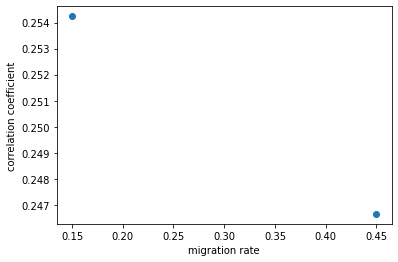

In [56]:
# plot the distribution of the correlation coefficients
plt.figure()
plt.scatter(f_arr,np.mean(corr_arr,axis=1))
plt.xlabel("migration rate")
plt.ylabel("correlation coefficient")

### train on half of 15 % migration time series

In [46]:
# first check if the characteristics of the 1st half and the 2nd half of the time series are the same

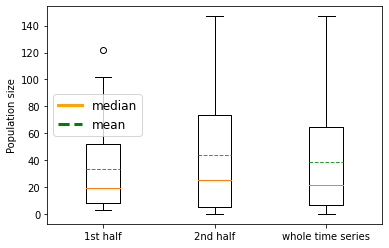

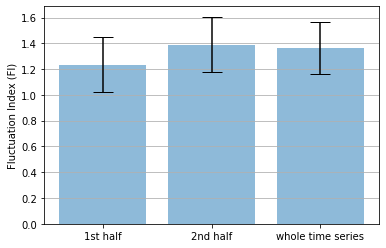

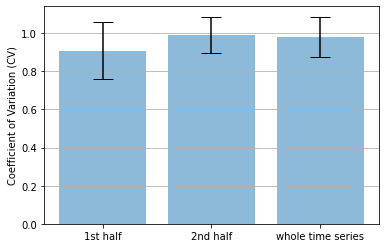

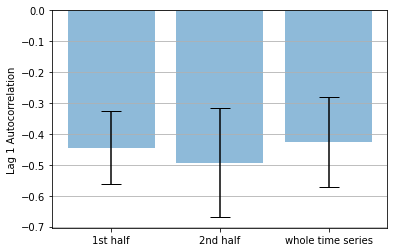

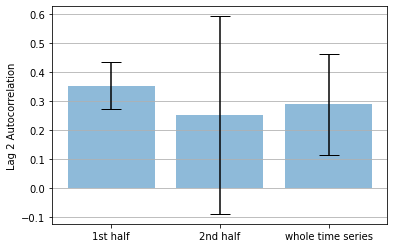

In [47]:
# patch 1
plot_charateristics([migration_15_nadult_matrix1[half1,:],migration_15_nadult_matrix1[half2,:],migration_15_nadult_matrix1],["1st half","2nd half","whole time series"])

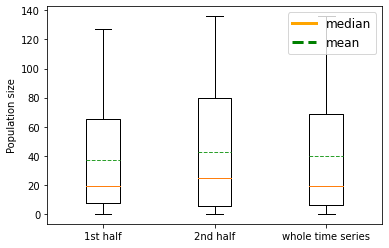

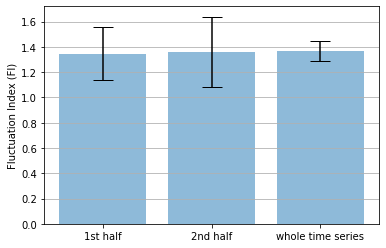

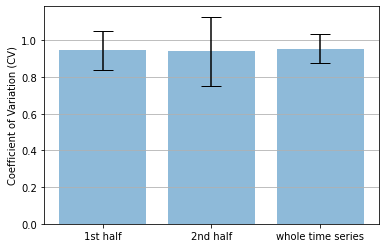

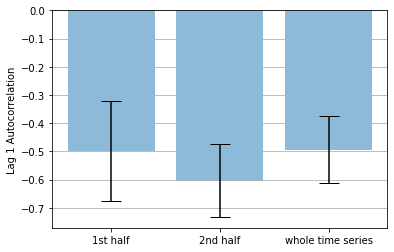

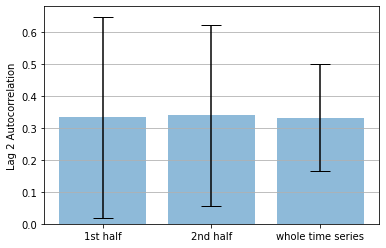

In [48]:
# patch 2
plot_charateristics([migration_15_nadult_matrix2[half1,:],migration_15_nadult_matrix2[half2,:],migration_15_nadult_matrix2],["1st half","2nd half","whole time series"])

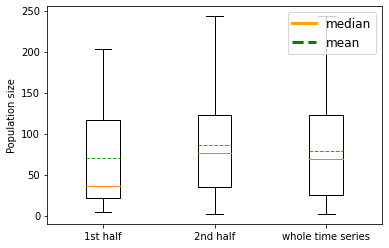

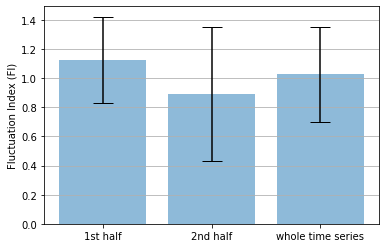

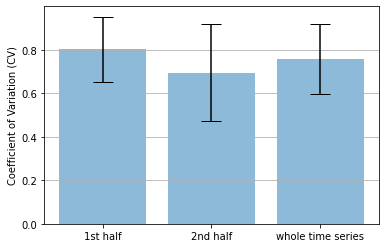

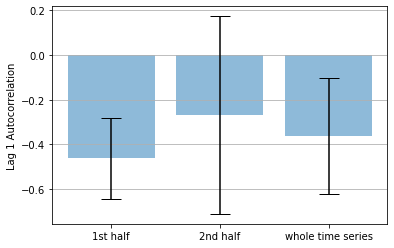

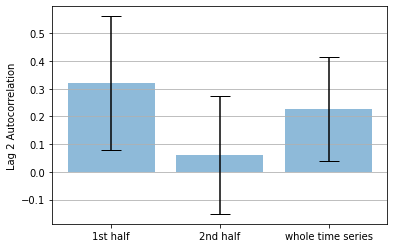

In [49]:
# metapopulation
plot_charateristics([migration_15_metapop_nadult_matrix[half1,:],migration_15_metapop_nadult_matrix[half2,:],migration_15_metapop_nadult_matrix],["1st half","2nd half","whole time series"])

In [45]:
half1 = np.arange(0,13)
half2 = np.arange(13,26)

In [ ]:
# train on the first half 

#  8 values of food × 58 sen_adden × 20 sen_adsize × 14 adnut = 129,920 combinations
# the number of individual parameters (low like 8 or high like 58) has been decided based on the importance of the parameter in affecting the dynamics
food_arr = np.arange(1.16,2.76,0.2) # 8 values
sen_adden_arr = np.arange(0.01,1.16,0.02) # 58 values
sen_adsize_arr = np.arange(0.2,4.2,0.2) # 20 values
adnut_arr = np.arange(1.15,3.20,0.15) # 14 values

combinations = list(it.product(food_arr,sen_adden_arr,sen_adsize_arr,adnut_arr))
# for each combination, do 50 simulations and calculate the cost function. 
# store the combination and the cost function in a 2D array
f = 0.15
numegg = 18
generations = 26
replicates = 50

combn_cost_funcn_arr = np.zeros([len(combinations),5]) # 1st column is food, 2nd column is sen_adden, 3rd column is sen_adsize, 4th column is adnut, 5th column is cost function
for i in range(len(combinations)):
    food = combinations[i][0]
    sen_adden = combinations[i][1]
    sen_adsize = combinations[i][2]
    adnut = combinations[i][3]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    combn_cost_funcn_arr[i,0] = food
    combn_cost_funcn_arr[i,1] = sen_adden
    combn_cost_funcn_arr[i,2] = sen_adsize
    combn_cost_funcn_arr[i,3] = adnut
    combn_cost_funcn_arr[i,4] =  cost_function(migration_15_nadult_matrix1[half1,:],LHLH_numadult_matrix1[half1,:]) + cost_function(migration_15_nadult_matrix2[half1,:],LHLH_numadult_matrix2[half1,:])
    # print i after every 1000 iterations
    if i%1000 == 0:
        print(i)
# store the cost function array in a csv file
np.savetxt(f"cost_function_array_patch_data_half1_f15.csv",combn_cost_funcn_arr,delimiter=",")
# trained on half of the time series of replicates 1,2,3 and 4

In [57]:
# read the cost function array from the csv file
# find the combination with the lowest cost function
combn_cost_funcn_arr = np.loadtxt("cost_function_array_patch_data_half1_f15.csv",delimiter=",")
min_cost_index = np.argmin(combn_cost_funcn_arr[:,4])
optimum_params = combn_cost_funcn_arr[min_cost_index,0:4]
print(optimum_params)

[1.76 0.09 0.2  1.75]


Patch 1


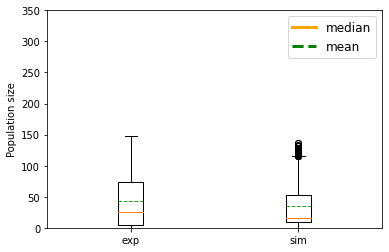

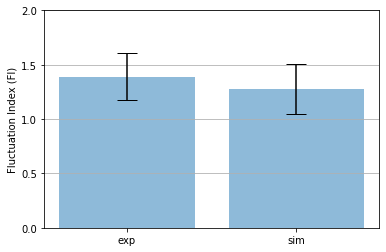

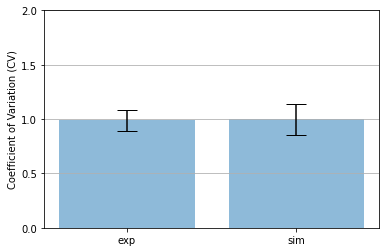

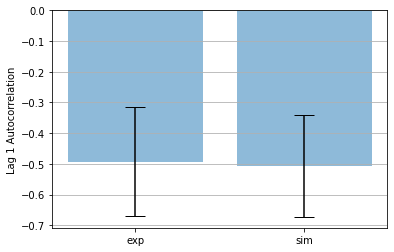

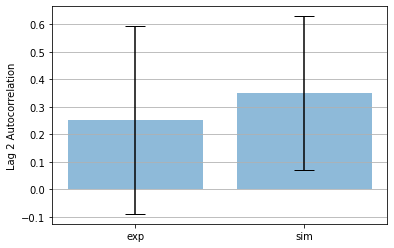

Patch 2


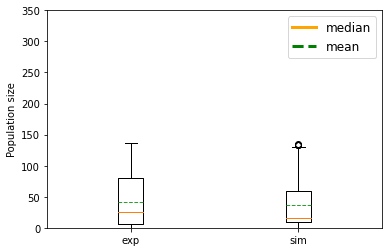

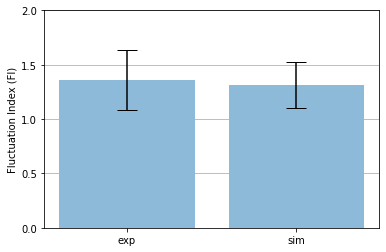

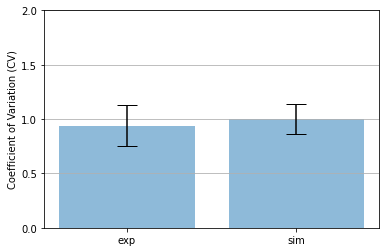

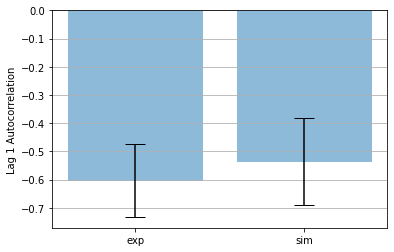

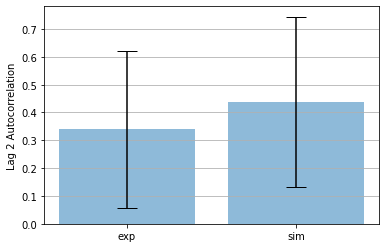

Metapopulation


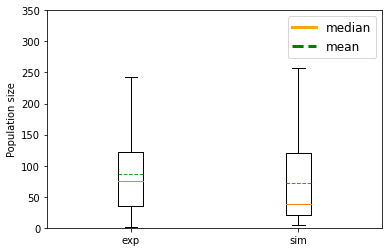

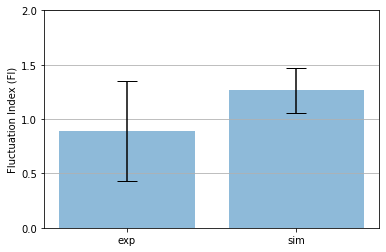

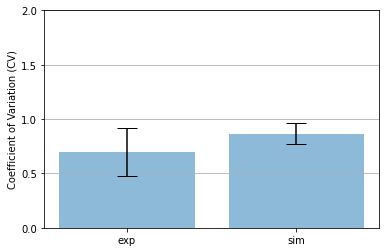

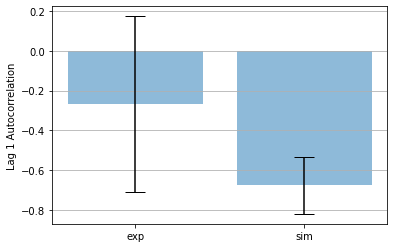

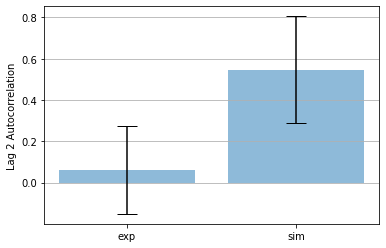

In [58]:
# check if the opt parameters can capture the dynamics of the 2nd half of the time series
food = optimum_params[0]
sen_adden = optimum_params[1]
sen_adsize = optimum_params[2]
adnut = optimum_params[3]
f = 0.15
generations = 26
replicates = 50
numegg = 18
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
print("Patch 1")
plot_validation(migration_15_nadult_matrix1[half2,:],LHLH_numadult_matrix1[half2,:])
print("Patch 2")
plot_validation(migration_15_nadult_matrix2[half2,:],LHLH_numadult_matrix2[half2,:])
print("Metapopulation")
plot_validation(migration_15_metapop_nadult_matrix[half2,:],LHLH_metapop_nadult_matrix[half2,:])

Patch 1


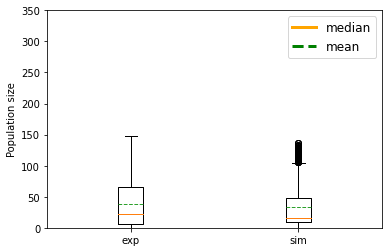

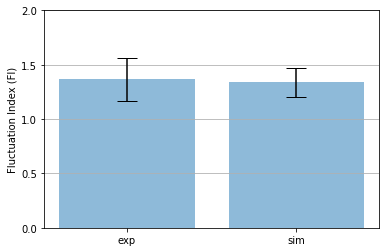

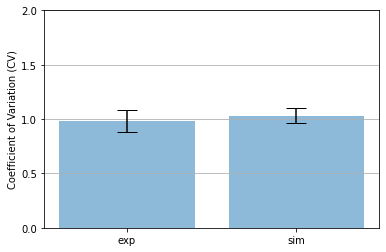

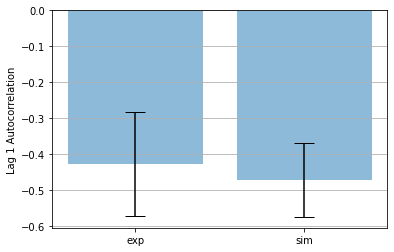

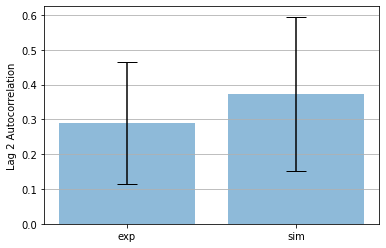

Patch 2


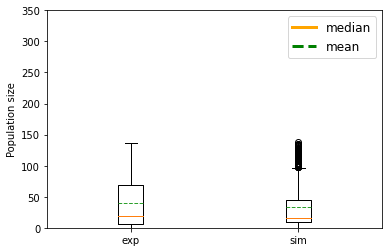

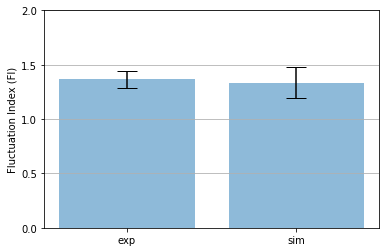

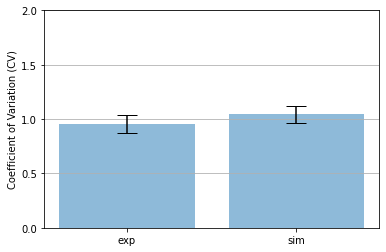

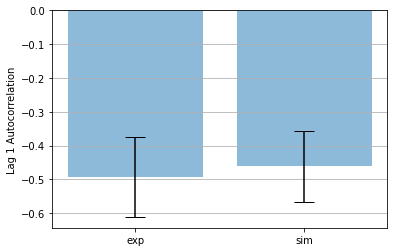

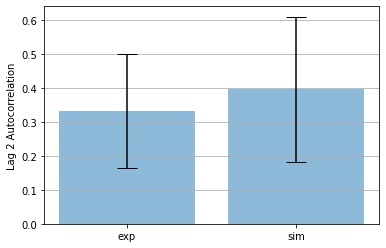

Metapopulation


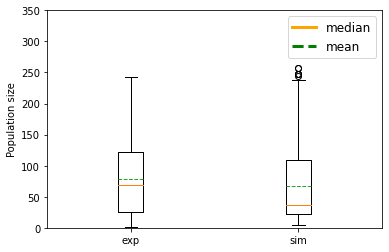

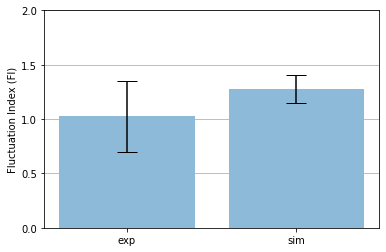

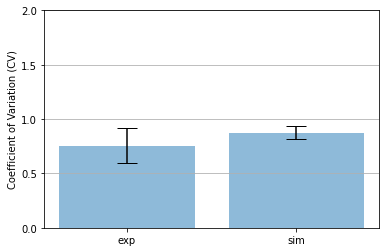

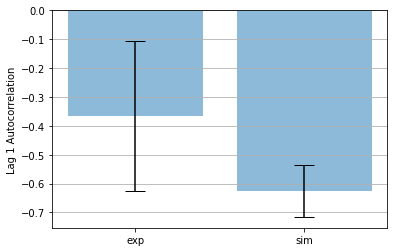

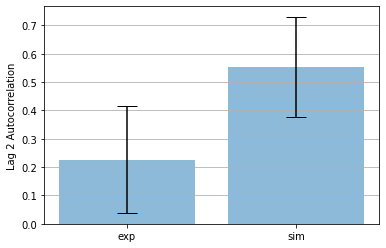

In [59]:
# whole time series
print("Patch 1")
plot_validation(migration_15_nadult_matrix1,LHLH_numadult_matrix1)
print("Patch 2")
plot_validation(migration_15_nadult_matrix2,LHLH_numadult_matrix2)
print("Metapopulation")
plot_validation(migration_15_metapop_nadult_matrix,LHLH_metapop_nadult_matrix)

In [60]:
## use KS 2 sample test to check if the adult number distributions of the experimental data and the simulated data are the same

##patch 1
# 2nd half of the time series
exp_data = migration_15_nadult_matrix1[half2,:].flatten()
sim_data = LHLH_numadult_matrix1[half2,:].flatten()
print("Patch 1 (2nd half) \n",stats.ks_2samp(exp_data,sim_data))
# entire time series
exp_data = migration_15_nadult_matrix1.flatten()
sim_data = LHLH_numadult_matrix1.flatten()
#sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 1 (entire time seies) \n",stats.ks_2samp(exp_data,sim_data))

##patch 1
# 2nd half of the time series
exp_data = migration_15_nadult_matrix2[half2,:].flatten()
sim_data = LHLH_numadult_matrix2[half2,:].flatten()
print("Patch 2 (2nd half) \n",stats.ks_2samp(exp_data,sim_data))
# entire time series
exp_data = migration_15_nadult_matrix2.flatten()
sim_data = LHLH_numadult_matrix2.flatten()
#sim_data = LHLH_numadult_matrix1.flatten()
print("Patch 2 (entire time seies) \n",stats.ks_2samp(exp_data,sim_data))

## metapopulation
# 2nd half of the time series
exp_data = migration_15_metapop_nadult_matrix[half2,:].flatten()
sim_data = LHLH_metapop_nadult_matrix[half2,:].flatten()
print("Metapopulation (2nd half) \n",stats.ks_2samp(exp_data,sim_data))

# entire time series
exp_data = migration_15_metapop_nadult_matrix.flatten()
sim_data = LHLH_metapop_nadult_matrix.flatten()
print("Metapopulation (entire time series) \n",stats.ks_2samp(exp_data,sim_data))

Patch 1 (2nd half) 
 KstestResult(statistic=0.2569230769230769, pvalue=0.002769318676089191)
Patch 1 (entire time seies) 
 KstestResult(statistic=0.2026923076923077, pvalue=0.0006112468708302087)
Patch 2 (2nd half) 
 KstestResult(statistic=0.21923076923076923, pvalue=0.01654374716962286)
Patch 2 (entire time seies) 
 KstestResult(statistic=0.19, pvalue=0.0016314249132980988)
Metapopulation (2nd half) 
 KstestResult(statistic=0.25076923076923074, pvalue=0.0037829475742500646)
Metapopulation (entire time series) 
 KstestResult(statistic=0.18307692307692308, pvalue=0.002711707196421029)


### test on metapopulation data

In [92]:
## test the optimum parameters to see how well metapop 3 and 4 are predicted
food = 2
sen_adden = 0.17
sen_adsize = 1.7
adnut = 1.49
generations = 26
replicates = 25
f = 0.45
numegg = 18
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)


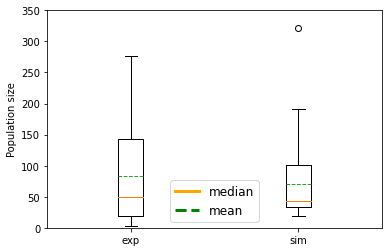

In [34]:
#boxplot of the population sizes
all_points_list = [migration_45_metapop_nadult_matrix[:,2:4].flatten(),LHLH_metapop_nadult_matrix.flatten()]
plt.boxplot(all_points_list,meanline=True,showmeans=True)
plt.ylim(0, 350)
plt.xticks([1, 2], ['exp', 'sim'])
plt.ylabel('Population size')
myHandle = [Line2D([], [], color='orange', lw = 3), Line2D([], [], color='green', linestyle = "dashed", lw = 3)]
plt.legend(handles = myHandle, labels=['median', 'mean'], frameon = True, loc = 'best', fontsize = 12)


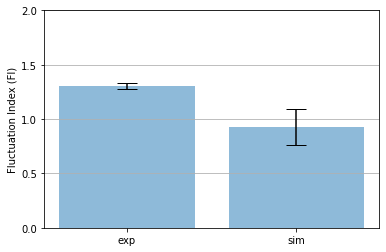

In [35]:
###barplot of fluctuation index
exp_FI_mean, exp_FI_sd = FI_numadult_matrix(migration_45_metapop_nadult_matrix[:,2:4])
sim_FI_mean, sim_FI_sd = FI_numadult_matrix(LHLH_metapop_nadult_matrix)

# Create lists for the plot
tags = ['exp', 'sim']
x_pos = np.arange(len(tags))
mean_FI = [exp_FI_mean, sim_FI_mean]
error_FI = [exp_FI_sd, sim_FI_sd]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean_FI, yerr=error_FI, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Fluctuation Index (FI)')
ax.set_xticks(x_pos)
ax.set_xticklabels(tags)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
plt.yticks(np.arange(0, 2.5, 0.5))
plt.show()

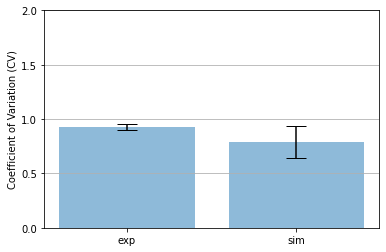

In [36]:
# barplt of CV

exp_CV_mean, exp_CV_sd = CV(migration_45_metapop_nadult_matrix[:,2:4])
sim_CV_mean, sim_CV_sd = CV(LHLH_metapop_nadult_matrix)

# Create lists for the plot
tags = ['exp', 'sim']
x_pos = np.arange(len(tags))
mean_CV = [exp_CV_mean, sim_CV_mean]
error_CV = [exp_CV_sd, sim_CV_sd]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean_CV, yerr=error_CV, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Coefficient of Variation (CV)')
ax.set_xticks(x_pos)
ax.set_xticklabels(tags)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
plt.yticks(np.arange(0, 2.5, 0.5))
plt.show()

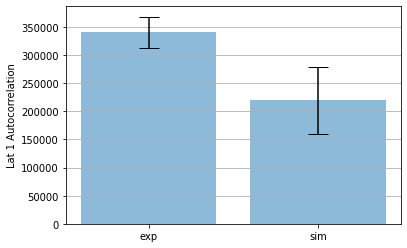

In [37]:
# barplot of lag 1 autocorrelation

exp_ac1_mean, exp_ac1_sd = autocrr_lag1(migration_45_metapop_nadult_matrix[:,2:4])
sim_ac1_mean, sim_ac1_sd = autocrr_lag1(LHLH_metapop_nadult_matrix)

# Create lists for the plot
tags = ['exp', 'sim']
x_pos = np.arange(len(tags))
mean_ac1 = [exp_ac1_mean,sim_ac1_mean]
error_ac1 = [exp_ac1_sd , sim_ac1_sd]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean_ac1, yerr=error_ac1, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Lat 1 Autocorrelation')
ax.set_xticks(x_pos)
ax.set_xticklabels(tags)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
#plt.yticks(np.arange(0, 2.5, 0.5))
plt.show()

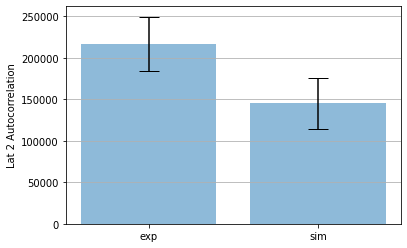

In [38]:
#barplot of lag 2 autocorrelation


exp_ac2_mean, exp_ac2_sd = autocrr_lag2(migration_45_metapop_nadult_matrix[:,2:4])
sim_ac2_mean, sim_ac2_sd = autocrr_lag2(LHLH_metapop_nadult_matrix)

# Create lists for the plot
tags = ['exp', 'sim']
x_pos = np.arange(len(tags))
mean_ac2 = [exp_ac2_mean,sim_ac2_mean]
error_ac2 = [exp_ac2_sd , sim_ac2_sd]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean_ac2, yerr=error_ac2, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Lat 2 Autocorrelation')
ax.set_xticks(x_pos)
ax.set_xticklabels(tags)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
#plt.yticks(np.arange(0, 2.5, 0.5))
plt.show()

In [ ]:
# so training on subpopulation level data and testing on metapopulation level data does not work well (is this actually bad?)

In [ ]:
# does it predict the subpopulation level data well?

### test on subpopulation data

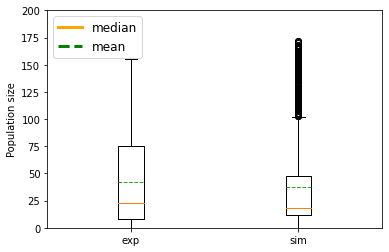

In [194]:
#boxplot of the population sizes
all_points_list = [np.column_stack([migration_45_nadult_matrix1[:,2:4],migration_45_nadult_matrix2[:,2:4]]).flatten(),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]).flatten()]
plt.boxplot(all_points_list,meanline=True,showmeans=True)
plt.ylim(0, 200)
plt.xticks([1, 2], ['exp', 'sim'])
plt.ylabel('Population size')
myHandle = [Line2D([], [], color='orange', lw = 3), Line2D([], [], color='green', linestyle = "dashed", lw = 3)]
plt.legend(handles = myHandle, labels=['median', 'mean'], frameon = True, loc = 'best', fontsize = 12)


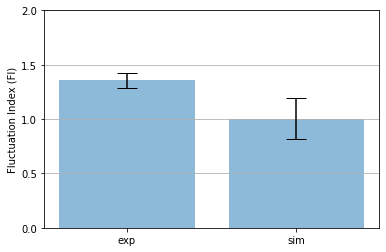

In [195]:
###barplot of fluctuation index
exp_FI_mean, exp_FI_sd = FI_numadult_matrix(np.column_stack([migration_45_nadult_matrix1[:,2:4],migration_45_nadult_matrix2[:,2:4]]))
sim_FI_mean, sim_FI_sd = FI_numadult_matrix(np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))

# Create lists for the plot
tags = ['exp', 'sim']
x_pos = np.arange(len(tags))
mean_FI = [exp_FI_mean, sim_FI_mean]
error_FI = [exp_FI_sd, sim_FI_sd]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean_FI, yerr=error_FI, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Fluctuation Index (FI)')
ax.set_xticks(x_pos)
ax.set_xticklabels(tags)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
plt.yticks(np.arange(0, 2.5, 0.5))
plt.show()


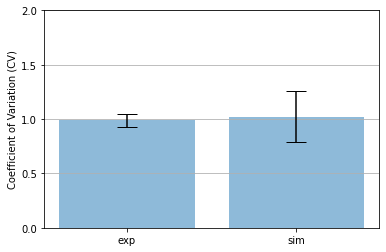

In [196]:
# barplt of CV

exp_CV_mean, exp_CV_sd = CV(np.column_stack([migration_45_nadult_matrix1[:,2:4],migration_45_nadult_matrix2[:,2:4]]))
sim_CV_mean, sim_CV_sd = CV(np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))

# Create lists for the plot
tags = ['exp', 'sim']
x_pos = np.arange(len(tags))
mean_CV = [exp_CV_mean, sim_CV_mean]
error_CV = [exp_CV_sd, sim_CV_sd]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean_CV, yerr=error_CV, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Coefficient of Variation (CV)')
ax.set_xticks(x_pos)
ax.set_xticklabels(tags)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
plt.yticks(np.arange(0, 2.5, 0.5))
plt.show()

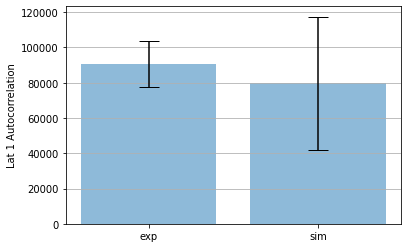

In [197]:
# barplot of lag 1 autocorrelation

exp_ac1_mean, exp_ac1_sd = autocrr_lag1(np.column_stack([migration_45_nadult_matrix1[:,2:4],migration_45_nadult_matrix2[:,2:4]]))
sim_ac1_mean, sim_ac1_sd = autocrr_lag1(np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))

# Create lists for the plot
tags = ['exp', 'sim']
x_pos = np.arange(len(tags))
mean_ac1 = [exp_ac1_mean,sim_ac1_mean]
error_ac1 = [exp_ac1_sd , sim_ac1_sd]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean_ac1, yerr=error_ac1, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Lat 1 Autocorrelation')
ax.set_xticks(x_pos)
ax.set_xticklabels(tags)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
#plt.yticks(np.arange(0, 2.5, 0.5))
plt.show()

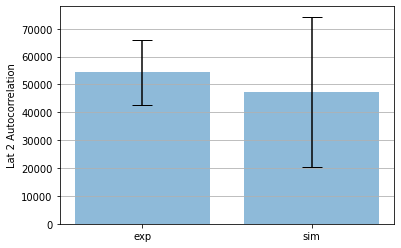

In [198]:
#barplot of lag 2 autocorrelation


exp_ac2_mean, exp_ac2_sd = autocrr_lag2(np.column_stack([migration_45_nadult_matrix1[:,2:4],migration_45_nadult_matrix2[:,2:4]]))
sim_ac2_mean, sim_ac2_sd = autocrr_lag2(np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))

# Create lists for the plot
tags = ['exp', 'sim']
x_pos = np.arange(len(tags))
mean_ac2 = [exp_ac2_mean,sim_ac2_mean]
error_ac2 = [exp_ac2_sd , sim_ac2_sd]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, mean_ac2, yerr=error_ac2, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Lat 2 Autocorrelation')
ax.set_xticks(x_pos)
ax.set_xticklabels(tags)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
#plt.yticks(np.arange(0, 2.5, 0.5))
plt.show()

### try cross validation 

In [ ]:
# train + validation - metapop 1,2 and 3
# test - metapop 4
# train on patch data of two metapops and validate on metapop data of the remaining metapop
# test on metapop data 



In [ ]:
# we narrowed down the parameter space when we trained on subpop data of matapops 1 and 2
# check if this parameter space is still valid when we train on subpop data of metapops 2,3 and metapops 1,3 respectively


In [ ]:
# cost function will be between patch 1 and 2 of exp metapop 2 and 3 and 25 replicates of sim patch 1 and 2 

Text(0, 0.5, 'cost function')

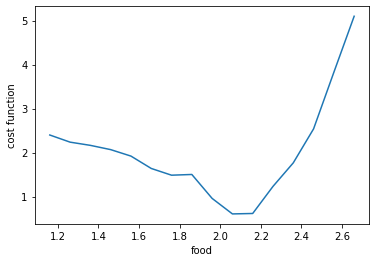

In [40]:
# vary food from 1.16 to 2.76 in steps of 0.1
# sen_adden = 0.17
# sen_adsize = 1.7
# adnut = 1.49 (constant values from the 2019 paper)

food_arr = np.arange(1.16,2.76,0.1)
sen_adden = 0.17
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([len(food_arr),1]) 
for i in range(len(food_arr)):
    food = food_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    cost_funcn_arr[i] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,1:3],migration_45_nadult_matrix2[:,1:3]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))
plt.plot(food_arr,cost_funcn_arr)
plt.xlabel("food")
plt.ylabel("cost function")

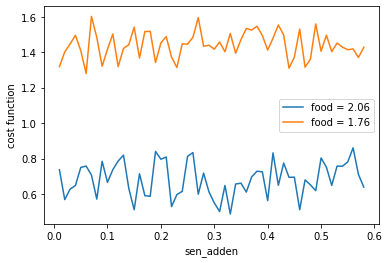

In [42]:
# vary sen_adden from 0.01 to 0.59 in steps of 0.01
# 2 values of food; food = 2.06 (optimum from above) and food = 1.76 (2019 paper)
# sen_adsize = 1.7
# adnut = 1.49 

sen_adden_arr = np.arange(0.01,0.59,0.01)
food_arr = [2.06,1.76]
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([2,len(sen_adden_arr)]) # 1st row is food = 2.06, 2nd row is food = 1.76 
for i in range(len(food_arr)):
    food = food_arr[i]
    for j in range(len(sen_adden_arr)):

        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        cost_funcn_arr[i][j] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,1:3],migration_45_nadult_matrix2[:,1:3]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))
plt.plot(sen_adden_arr,cost_funcn_arr[0,:],label = "food = 2.06")
plt.plot(sen_adden_arr,cost_funcn_arr[1,:],label = "food = 1.76")
plt.xlabel("sen_adden")
plt.ylabel("cost function")
plt.legend()
plt.show()

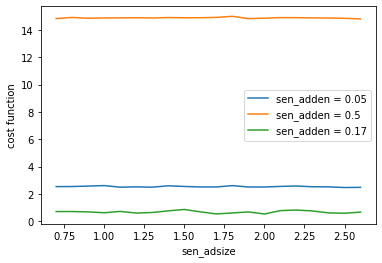

In [43]:
# vary sen_adsize from 0.7 to 2.7 in steps of 0.1 
# food = 2.06 (as it is better than 1.76)
# three values of sen_adden; sen_adden = 0.05,0.5 (random) and sen_adden = 0.17 (2019 paper)
# adnut = 1.49

sen_adsize_arr = np.arange(0.7,2.7,0.1)
food = 2.06
sen_adden_arr = [0.05,0.5,0.17]
adnut = 1.49
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([3,len(sen_adsize_arr)]) # 1st row is sen_adden = 0.05, 2nd row is sen_adden = 0.5, 3rd row is sen_adden = 0.17
for i in range(len(sen_adden_arr)):
    sen_adden = sen_adden_arr[i]
    for j in range(len(sen_adsize_arr)):

        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        cost_funcn_arr[i][j] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,1:3],migration_45_nadult_matrix2[:,1:3]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))


plt.plot(sen_adsize_arr,cost_funcn_arr[0,:],label = "sen_adden = 0.05")
plt.plot(sen_adsize_arr,cost_funcn_arr[1,:],label = "sen_adden = 0.5")
plt.plot(sen_adsize_arr,cost_funcn_arr[2,:],label = "sen_adden = 0.17")
plt.xlabel("sen_adsize")
plt.ylabel("cost function")
plt.legend()
plt.show()

Text(0, 0.5, 'cost function')

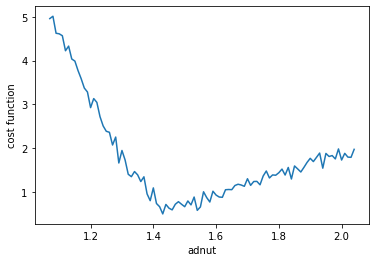

In [44]:
# vary adnut from 1.07 to 2.05 in steps of 0.01
# food = 2.06 
# sen_adden = 0.17
# sen_adsize = 1.7

adnut_arr = np.arange(1.07,2.05,0.01)
food = 2.06
sen_adden = 0.17
sen_adsize = 1.7
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([len(adnut_arr),1])
for i in range(len(adnut_arr)):
    adnut = adnut_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    cost_funcn_arr[i] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,1:3],migration_45_nadult_matrix2[:,1:3]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))

plt.plot(adnut_arr,cost_funcn_arr)
plt.xlabel("adnut")
plt.ylabel("cost function")

In [ ]:
# cost function will be between patch 1 and 2 of exp metapop 1 and 3 and 25 replicates of sim patch 1 and 2 

Text(0, 0.5, 'cost function')

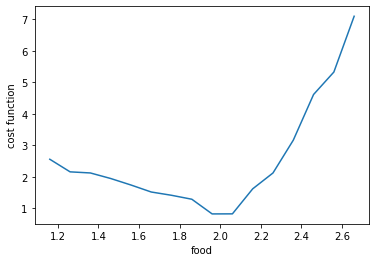

In [50]:
# vary food from 1.16 to 2.76 in steps of 0.1
# sen_adden = 0.17
# sen_adsize = 1.7
# adnut = 1.49 (constant values from the 2019 paper)

food_arr = np.arange(1.16,2.76,0.1)
sen_adden = 0.17
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([len(food_arr),1]) 
for i in range(len(food_arr)):
    food = food_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    cost_funcn_arr[i] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,[0,2]],migration_45_nadult_matrix2[:,[0,2]]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))
plt.plot(food_arr,cost_funcn_arr)
plt.xlabel("food")
plt.ylabel("cost function")

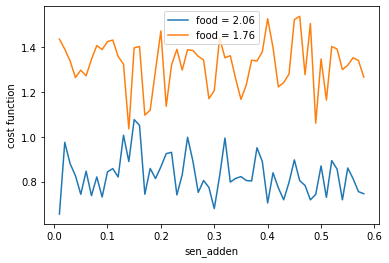

In [52]:
# vary sen_adden from 0.01 to 0.59 in steps of 0.01
# 2 values of food; food = 2.06 (optimum from above) and food = 1.76 (2019 paper)
# sen_adsize = 1.7
# adnut = 1.49 

sen_adden_arr = np.arange(0.01,0.59,0.01)
food_arr = [2.06,1.76]
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([2,len(sen_adden_arr)]) # 1st row is food = 2.06, 2nd row is food = 1.76 
for i in range(len(food_arr)):
    food = food_arr[i]
    for j in range(len(sen_adden_arr)):

        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        cost_funcn_arr[i][j] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,[0,2]],migration_45_nadult_matrix2[:,[0,2]]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))
plt.plot(sen_adden_arr,cost_funcn_arr[0,:],label = "food = 2.06")
plt.plot(sen_adden_arr,cost_funcn_arr[1,:],label = "food = 1.76")
plt.xlabel("sen_adden")
plt.ylabel("cost function")
plt.legend()
plt.show()

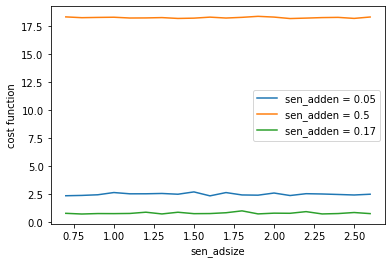

In [53]:
# vary sen_adsize from 0.7 to 2.7 in steps of 0.1 
# food = 2.06 (as it is better than 1.76)
# three values of sen_adden; sen_adden = 0.05,0.5 (from above) and sen_adden = 0.17 (2019 paper)
# adnut = 1.49

sen_adsize_arr = np.arange(0.7,2.7,0.1)
food = 2.06
sen_adden_arr = [0.05,0.5,0.17]
adnut = 1.49
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([3,len(sen_adsize_arr)]) # 1st row is sen_adden = 0.05, 2nd row is sen_adden = 0.5, 3rd row is sen_adden = 0.17
for i in range(len(sen_adden_arr)):
    sen_adden = sen_adden_arr[i]
    for j in range(len(sen_adsize_arr)):

        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        cost_funcn_arr[i][j] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,[0,2]],migration_45_nadult_matrix2[:,[0,2]]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))


plt.plot(sen_adsize_arr,cost_funcn_arr[0,:],label = "sen_adden = 0.05")
plt.plot(sen_adsize_arr,cost_funcn_arr[1,:],label = "sen_adden = 0.5")
plt.plot(sen_adsize_arr,cost_funcn_arr[2,:],label = "sen_adden = 0.17")
plt.xlabel("sen_adsize")
plt.ylabel("cost function")
plt.legend()
plt.show()

Text(0, 0.5, 'cost function')

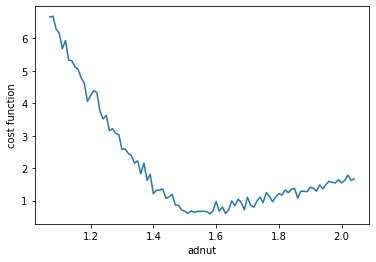

In [54]:
# vary adnut from 1.07 to 2.05 in steps of 0.01
# food = 2.06 
# sen_adden = 0.17
# sen_adsize = 1.7

adnut_arr = np.arange(1.07,2.05,0.01)
food = 2.06
sen_adden = 0.17
sen_adsize = 1.7
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([len(adnut_arr),1])
for i in range(len(adnut_arr)):
    adnut = adnut_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    cost_funcn_arr[i] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,[0,2]],migration_45_nadult_matrix2[:,[0,2]]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))

plt.plot(adnut_arr,cost_funcn_arr)
plt.xlabel("adnut")
plt.ylabel("cost function")

In [ ]:
# so the parameter space is still valid when we train on subpop data of metapops 2,3 and metapops 1,3 respectively
# would k fold cross validation help then?

In [70]:
# now simultaneously vary food, sen_adden, sen_adsize and adnut
# food from 2 to 2.2 in steps of 0.02
# sen_adden from 0.11 to 0.19 in steps of 0.01
# sen_adsize from 1.5 to 1.9 in steps of 0.02
# adnut from 1.45 to 1.55 in steps of 0.01

food_arr = np.arange(2,2.2,0.02)
sen_adden_arr = np.arange(0.11,0.19,0.01)
sen_adsize_arr = np.arange(1.5,1.9,0.02)
adnut_arr = np.arange(1.45,1.55,0.01)

combinations = list(it.product(food_arr,sen_adden_arr,sen_adsize_arr,adnut_arr))
# for each combination, do 50 simulations and calculate the cost function. 
# store the combination and the cost function in a 2D array
f = 0.45
numegg = 18
generations = 26
replicates = 25


for j in range(0,2): # metapopulation j+1 is the validation set and the rest are the training set
    combn_cost_funcn_arr = np.zeros([len(combinations),5]) # 1st column is food, 2nd column is sen_adden, 3rd column is sen_adsize, 4th column is adnut, 5th column is cost function
    for i in range(len(combinations)):
        food = combinations[i][0]
        sen_adden = combinations[i][1]
        sen_adsize = combinations[i][2]
        adnut = combinations[i][3]
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        #LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        combn_cost_funcn_arr[i,0] = food
        combn_cost_funcn_arr[i,1] = sen_adden
        combn_cost_funcn_arr[i,2] = sen_adsize
        combn_cost_funcn_arr[i,3] = adnut
        combn_cost_funcn_arr[i,4] = cost_function(np.column_stack([migration_45_nadult_matrix1[:,[x for x in range(0,2) if x != j]],migration_45_nadult_matrix2[:,[x for x in range(0,2) if x != j]]]),np.column_stack([LHLH_numadult_matrix1,LHLH_numadult_matrix2]))
    # store the cost function array in a csv file
    np.savetxt(f"cv_subpop_metapop\cost_function_array_valid{j+1}.csv",combn_cost_funcn_arr,delimiter=",") 

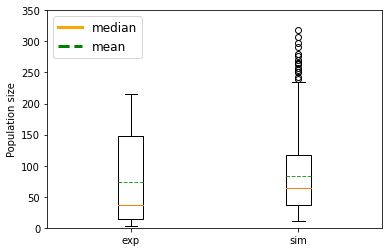

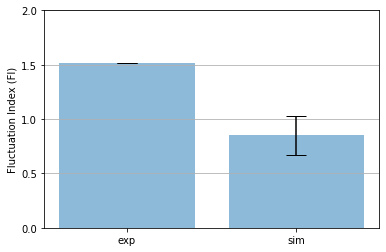

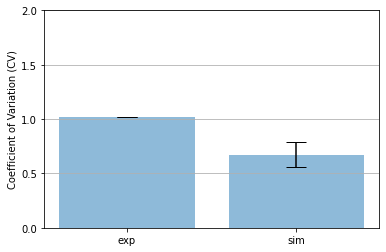

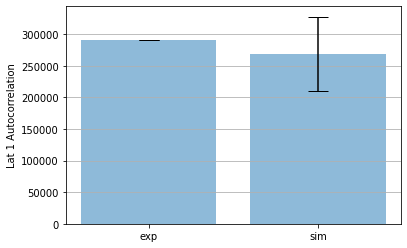

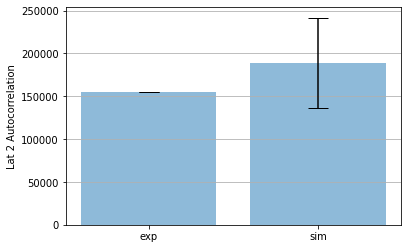

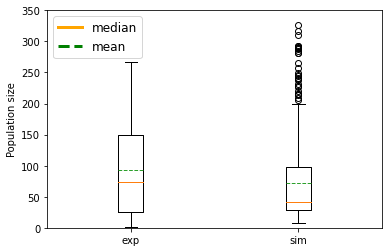

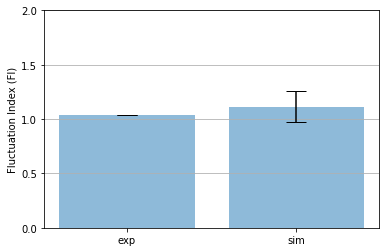

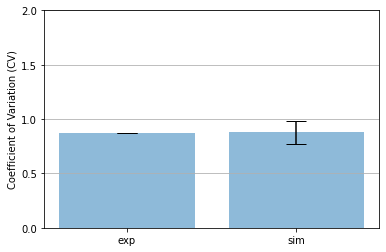

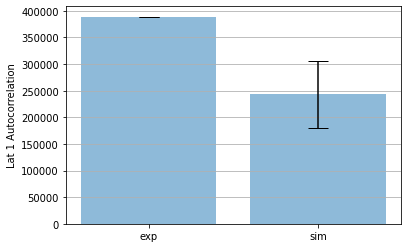

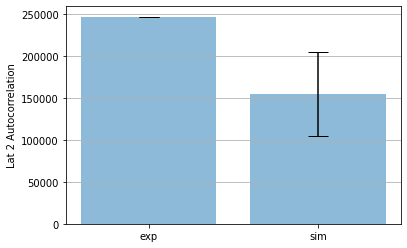

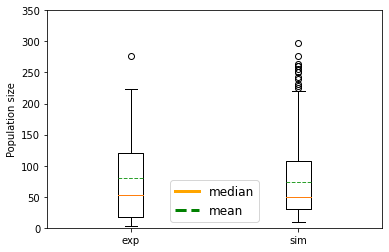

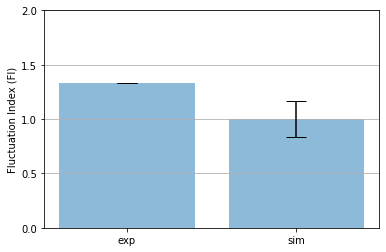

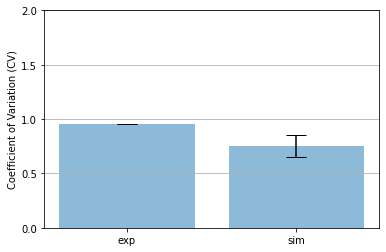

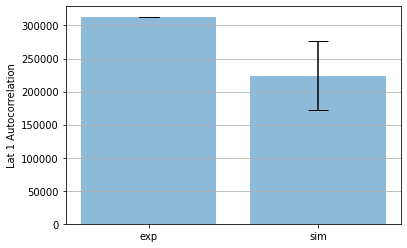

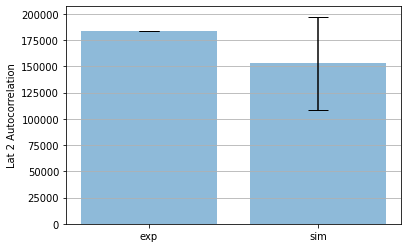

In [71]:
# load the matrices from the csv files and then find the combination with the lowest cost function

opt_params_arr = np.zeros([3,4]) # for the three arrays
for i in range(1,4):
    cost_funcn_arr = np.loadtxt(f"cv_subpop_metapop\cost_function_array_valid{i}.csv",delimiter=",")
    opt_params_arr[i-1,:] = cost_funcn_arr[np.argmin(cost_funcn_arr[:,4]),0:4]

    # run simulation with opt params
    food = opt_params_arr[i-1,0]
    sen_adden = opt_params_arr[i-1,1]
    sen_adsize = opt_params_arr[i-1,2]
    adnut = opt_params_arr[i-1,3]
    f = 0.45
    generations = 26
    replicates = 25
    numegg = 18
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)

    # plot validation set and simulation set

    plot_validation(migration_45_metapop_nadult_matrix[:,i-1],LHLH_metapop_nadult_matrix)


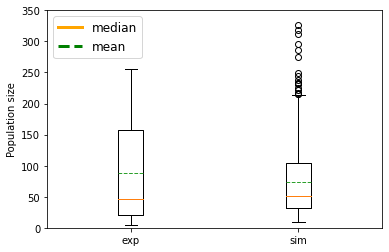

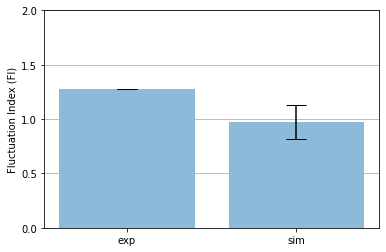

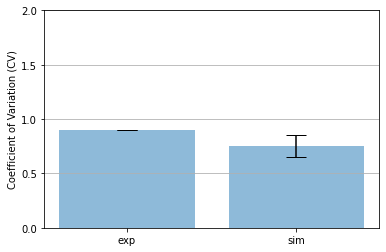

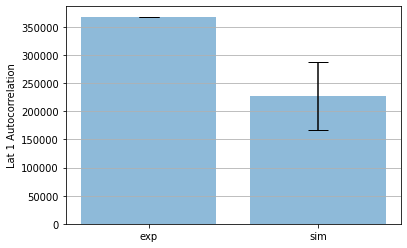

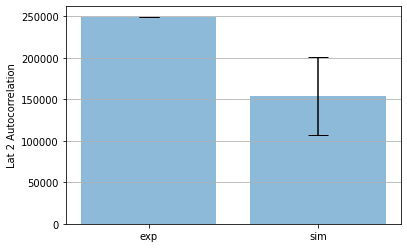

In [72]:
# take the average of the three opt_params_arr and run the simulation with these params
# test on metapop 4

opt_params = np.mean(opt_params_arr,axis = 0)
food = opt_params[0]
sen_adden = opt_params[1]
sen_adsize = opt_params[2]
adnut = opt_params[3]
f = 0.45
generations = 26
replicates = 25
numegg = 18
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)

# plot validation set and simulation set
plot_validation(migration_45_metapop_nadult_matrix[:,3],LHLH_metapop_nadult_matrix)

In [78]:
# correlation between the two patches
exp_corr = [Pearson_corr_patches(migration_45_nadult_matrix1[:,3],migration_45_nadult_matrix2[:,3]),Spearman_corr_patches(migration_45_nadult_matrix1[:,3],migration_45_nadult_matrix2[:,3])]
sim_corr = [Pearson_corr_patches(LHLH_numadult_matrix1,LHLH_numadult_matrix2),Spearman_corr_patches(LHLH_numadult_matrix1,LHLH_numadult_matrix2)]
print("correlation between the two patches:",exp_corr,sim_corr)

correlation between the two patches: [0.857687876251896, 0.7570205923379512] [0.03370233420733943, -0.05744669391075684]


### train on metapop data and test on metapop data as well


In [ ]:
# train + validation - metapop 1,2 and 3
# test - metapop 4
# train on two metapops and validate on metapop data of the remaining metapop
# test on metapop data of 4


In [ ]:
# narrow down the parameter space

In [ ]:
# cost function will be between exp metapop 1 and 2 and 50 replicates of sim metapop

Text(0, 0.5, 'cost function')

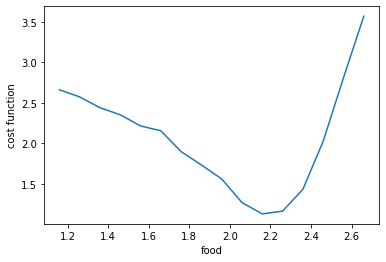

In [79]:
# vary food from 1.16 to 2.76 in steps of 0.1
# sen_adden = 0.17
# sen_adsize = 1.7
# adnut = 1.49 (constant values from the 2019 paper)

food_arr = np.arange(1.16,2.76,0.1)
sen_adden = 0.17
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 50
numegg = 18
cost_funcn_arr = np.zeros([len(food_arr),1]) 
for i in range(len(food_arr)):
    food = food_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    cost_funcn_arr[i] = cost_function(migration_45_metapop_nadult_matrix[:,[0,1]],LHLH_metapop_nadult_matrix)
plt.plot(food_arr,cost_funcn_arr)
plt.xlabel("food")
plt.ylabel("cost function")

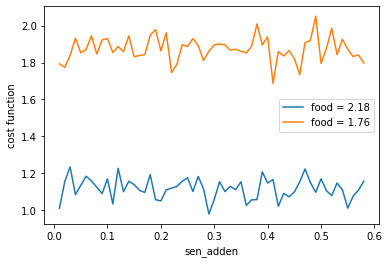

In [84]:
# vary sen_adden from 0.01 to 0.59 in steps of 0.01
# 2 values of food; food = 2.18 (optimum from above) and food = 1.76 (2019 paper)
# sen_adsize = 1.7
# adnut = 1.49 

sen_adden_arr = np.arange(0.01,0.59,0.01)
food_arr = [2.18,1.76]
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 50
numegg = 18
cost_funcn_arr = np.zeros([2,len(sen_adden_arr)]) # 1st row is food = 2.06, 2nd row is food = 1.76 
for i in range(len(food_arr)):
    food = food_arr[i]
    for j in range(len(sen_adden_arr)):
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        cost_funcn_arr[i][j] = cost_function(migration_45_metapop_nadult_matrix[:,[0,1]],LHLH_metapop_nadult_matrix)
plt.plot(sen_adden_arr,cost_funcn_arr[0,:],label = "food = 2.18")
plt.plot(sen_adden_arr,cost_funcn_arr[1,:],label = "food = 1.76")
plt.xlabel("sen_adden")
plt.ylabel("cost function")
plt.legend()
plt.show()

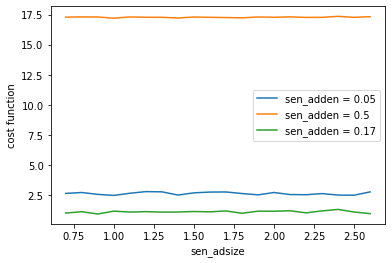

In [83]:
# vary sen_adsize from 0.7 to 2.7 in steps of 0.1 
# food = 2.06 (as it is better than 1.76)
# three values of sen_adden; sen_adden = 0.05,0.5 (random) and sen_adden = 0.17 (2019 paper)
# adnut = 1.49

sen_adsize_arr = np.arange(0.7,2.7,0.1)
food = 2.18
sen_adden_arr = [0.05,0.5,0.17]
adnut = 1.49
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([3,len(sen_adsize_arr)]) # 1st row is sen_adden = 0.05, 2nd row is sen_adden = 0.5, 3rd row is sen_adden = 0.17
for i in range(len(sen_adden_arr)):
    sen_adden = sen_adden_arr[i]
    for j in range(len(sen_adsize_arr)):
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        cost_funcn_arr[i][j] = cost_function(migration_45_metapop_nadult_matrix[:,[0,1]],LHLH_metapop_nadult_matrix)


plt.plot(sen_adsize_arr,cost_funcn_arr[0,:],label = "sen_adden = 0.05")
plt.plot(sen_adsize_arr,cost_funcn_arr[1,:],label = "sen_adden = 0.5")
plt.plot(sen_adsize_arr,cost_funcn_arr[2,:],label = "sen_adden = 0.17")
plt.xlabel("sen_adsize")
plt.ylabel("cost function")
plt.legend()
plt.show()

Text(0, 0.5, 'cost function')

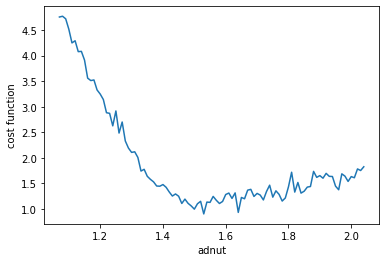

In [85]:
# vary adnut from 1.07 to 2.05 in steps of 0.01
# food = 2.18 
# sen_adden = 0.17
# sen_adsize = 1.7

adnut_arr = np.arange(1.07,2.05,0.01)
food = 2.18
sen_adden = 0.17
sen_adsize = 1.7
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([len(adnut_arr),1])
for i in range(len(adnut_arr)):
    adnut = adnut_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    cost_funcn_arr[i] = cost_function(migration_45_metapop_nadult_matrix[:,[0,1]],LHLH_metapop_nadult_matrix)

plt.plot(adnut_arr,cost_funcn_arr)
plt.xlabel("adnut")
plt.ylabel("cost function")

In [ ]:

#food_arr = np.arange(2.1,2.3,0.02)
#sen_adden_arr = np.arange(0.14,0.23,0.01)
#sen_adsize_arr = np.arange(1.5,1.9,0.02)
#adnut_arr = np.arange(1.45,1.55,0.01)

In [ ]:
# cost function will be between exp metapop 2 and 3 and 50 replicates of sim metapop

Text(0, 0.5, 'cost function')

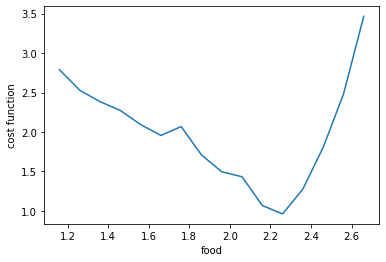

In [86]:
# vary food from 1.16 to 2.76 in steps of 0.1
# sen_adden = 0.17
# sen_adsize = 1.7
# adnut = 1.49 (constant values from the 2019 paper)

food_arr = np.arange(1.16,2.76,0.1)
sen_adden = 0.17
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 50
numegg = 18
cost_funcn_arr = np.zeros([len(food_arr),1]) 
for i in range(len(food_arr)):
    food = food_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    cost_funcn_arr[i] = cost_function(migration_45_metapop_nadult_matrix[:,[1,2]],LHLH_metapop_nadult_matrix)
plt.plot(food_arr,cost_funcn_arr)
plt.xlabel("food")
plt.ylabel("cost function")

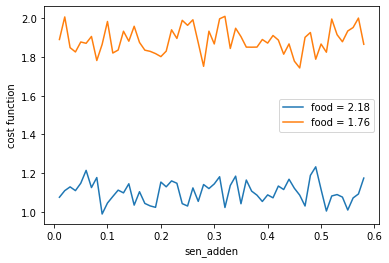

In [87]:
# vary sen_adden from 0.01 to 0.59 in steps of 0.01
# 2 values of food; food = 2.18 (optimum from above) and food = 1.76 (2019 paper)
# sen_adsize = 1.7
# adnut = 1.49 

sen_adden_arr = np.arange(0.01,0.59,0.01)
food_arr = [2.18,1.76]
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 50
numegg = 18
cost_funcn_arr = np.zeros([2,len(sen_adden_arr)]) # 1st row is food = 2.06, 2nd row is food = 1.76 
for i in range(len(food_arr)):
    food = food_arr[i]
    for j in range(len(sen_adden_arr)):
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        cost_funcn_arr[i][j] = cost_function(migration_45_metapop_nadult_matrix[:,[1,2]],LHLH_metapop_nadult_matrix)
plt.plot(sen_adden_arr,cost_funcn_arr[0,:],label = "food = 2.18")
plt.plot(sen_adden_arr,cost_funcn_arr[1,:],label = "food = 1.76")
plt.xlabel("sen_adden")
plt.ylabel("cost function")
plt.legend()
plt.show()

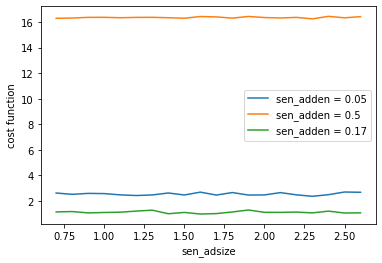

In [88]:
# vary sen_adsize from 0.7 to 2.7 in steps of 0.1 
# food = 2.18 (as it is better than 1.76)
# three values of sen_adden; sen_adden = 0.05,0.5 (random) and sen_adden = 0.17 (2019 paper)
# adnut = 1.49

sen_adsize_arr = np.arange(0.7,2.7,0.1)
food = 2.18
sen_adden_arr = [0.05,0.5,0.17]
adnut = 1.49
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([3,len(sen_adsize_arr)]) # 1st row is sen_adden = 0.05, 2nd row is sen_adden = 0.5, 3rd row is sen_adden = 0.17
for i in range(len(sen_adden_arr)):
    sen_adden = sen_adden_arr[i]
    for j in range(len(sen_adsize_arr)):
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        cost_funcn_arr[i][j] = cost_function(migration_45_metapop_nadult_matrix[:,[1,2]],LHLH_metapop_nadult_matrix)


plt.plot(sen_adsize_arr,cost_funcn_arr[0,:],label = "sen_adden = 0.05")
plt.plot(sen_adsize_arr,cost_funcn_arr[1,:],label = "sen_adden = 0.5")
plt.plot(sen_adsize_arr,cost_funcn_arr[2,:],label = "sen_adden = 0.17")
plt.xlabel("sen_adsize")
plt.ylabel("cost function")
plt.legend()
plt.show()

Text(0, 0.5, 'cost function')

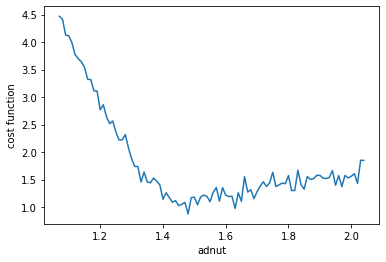

In [89]:
# vary adnut from 1.07 to 2.05 in steps of 0.01
# food = 2.18 
# sen_adden = 0.17
# sen_adsize = 1.7

adnut_arr = np.arange(1.07,2.05,0.01)
food = 2.18
sen_adden = 0.17
sen_adsize = 1.7
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([len(adnut_arr),1])
for i in range(len(adnut_arr)):
    adnut = adnut_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    cost_funcn_arr[i] = cost_function(migration_45_metapop_nadult_matrix[:,[1,2]],LHLH_metapop_nadult_matrix)

plt.plot(adnut_arr,cost_funcn_arr)
plt.xlabel("adnut")
plt.ylabel("cost function")

In [ ]:

#food_arr = np.arange(2.1,2.3,0.02)
#sen_adden_arr = np.arange(0.14,0.23,0.01)
#sen_adsize_arr = np.arange(1.5,1.9,0.02)
#adnut_arr = np.arange(1.45,1.55,0.01)

In [ ]:
# cost function will be between exp metapop 1 and 3 and 50 replicates of sim metapop

Text(0, 0.5, 'cost function')

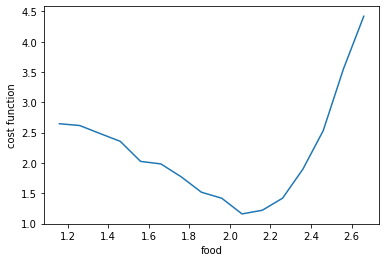

In [90]:
# vary food from 1.16 to 2.76 in steps of 0.1
# sen_adden = 0.17
# sen_adsize = 1.7
# adnut = 1.49 (constant values from the 2019 paper)

food_arr = np.arange(1.16,2.76,0.1)
sen_adden = 0.17
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 50
numegg = 18
cost_funcn_arr = np.zeros([len(food_arr),1]) 
for i in range(len(food_arr)):
    food = food_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    cost_funcn_arr[i] = cost_function(migration_45_metapop_nadult_matrix[:,[0,2]],LHLH_metapop_nadult_matrix)
plt.plot(food_arr,cost_funcn_arr)
plt.xlabel("food")
plt.ylabel("cost function")

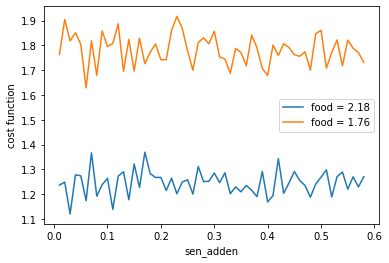

In [91]:
# vary sen_adden from 0.01 to 0.59 in steps of 0.01
# 2 values of food; food = 2.18 (optimum from above) and food = 1.76 (2019 paper)
# sen_adsize = 1.7
# adnut = 1.49 

sen_adden_arr = np.arange(0.01,0.59,0.01)
food_arr = [2.18,1.76]
sen_adsize = 1.7
adnut = 1.49
f = 0.45
generations = 26
replicates = 50
numegg = 18
cost_funcn_arr = np.zeros([2,len(sen_adden_arr)]) # 1st row is food = 2.06, 2nd row is food = 1.76 
for i in range(len(food_arr)):
    food = food_arr[i]
    for j in range(len(sen_adden_arr)):
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        cost_funcn_arr[i][j] = cost_function(migration_45_metapop_nadult_matrix[:,[0,2]],LHLH_metapop_nadult_matrix)
plt.plot(sen_adden_arr,cost_funcn_arr[0,:],label = "food = 2.18")
plt.plot(sen_adden_arr,cost_funcn_arr[1,:],label = "food = 1.76")
plt.xlabel("sen_adden")
plt.ylabel("cost function")
plt.legend()
plt.show()

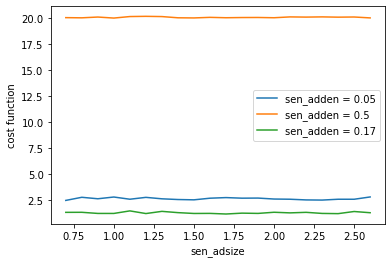

In [92]:
# vary sen_adsize from 0.7 to 2.7 in steps of 0.1 
# food = 2.18 (as it is better than 1.76)
# three values of sen_adden; sen_adden = 0.05,0.5 (random) and sen_adden = 0.17 (2019 paper)
# adnut = 1.49

sen_adsize_arr = np.arange(0.7,2.7,0.1)
food = 2.18
sen_adden_arr = [0.05,0.5,0.17]
adnut = 1.49
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([3,len(sen_adsize_arr)]) # 1st row is sen_adden = 0.05, 2nd row is sen_adden = 0.5, 3rd row is sen_adden = 0.17
for i in range(len(sen_adden_arr)):
    sen_adden = sen_adden_arr[i]
    for j in range(len(sen_adsize_arr)):
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        cost_funcn_arr[i][j] = cost_function(migration_45_metapop_nadult_matrix[:,[0,2]],LHLH_metapop_nadult_matrix)


plt.plot(sen_adsize_arr,cost_funcn_arr[0,:],label = "sen_adden = 0.05")
plt.plot(sen_adsize_arr,cost_funcn_arr[1,:],label = "sen_adden = 0.5")
plt.plot(sen_adsize_arr,cost_funcn_arr[2,:],label = "sen_adden = 0.17")
plt.xlabel("sen_adsize")
plt.ylabel("cost function")
plt.legend()
plt.show()

Text(0, 0.5, 'cost function')

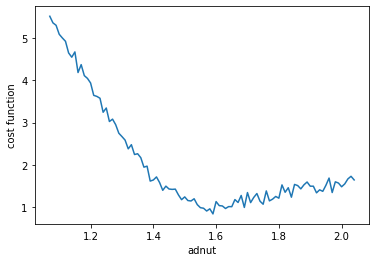

In [94]:
# vary adnut from 1.07 to 2.05 in steps of 0.01
# food = 2.18 
# sen_adden = 0.17
# sen_adsize = 1.7

adnut_arr = np.arange(1.07,2.05,0.01)
food = 2.18
sen_adden = 0.17
sen_adsize = 1.7
f = 0.45
generations = 26
replicates = 25
numegg = 18
cost_funcn_arr = np.zeros([len(adnut_arr),1])
for i in range(len(adnut_arr)):
    adnut = adnut_arr[i]
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
    cost_funcn_arr[i] = cost_function(migration_45_metapop_nadult_matrix[:,[0,2]],LHLH_metapop_nadult_matrix)

plt.plot(adnut_arr,cost_funcn_arr)
plt.xlabel("adnut")
plt.ylabel("cost function")

In [ ]:

#food_arr = np.arange(2.1,2.3,0.02)
#sen_adden_arr = np.arange(0.14,0.23,0.01)
#sen_adsize_arr = np.arange(1.5,1.9,0.02)
#adnut_arr = np.arange(1.45,1.65,0.02)

In [95]:
# now simultaneously vary food, sen_adden, sen_adsize and adnut
# food from 2 to 2.2 in steps of 0.02
# sen_adden from 0.11 to 0.19 in steps of 0.01
# sen_adsize from 1.5 to 1.9 in steps of 0.02
# adnut from 1.45 to 1.55 in steps of 0.01

food_arr = np.arange(2.1,2.3,0.02)
sen_adden_arr = np.arange(0.11,0.19,0.01)
sen_adsize_arr = np.arange(1.5,1.9,0.02)
adnut_arr = np.arange(1.45,1.65,0.02)

combinations = list(it.product(food_arr,sen_adden_arr,sen_adsize_arr,adnut_arr))
# for each combination, do 50 simulations and calculate the cost function. 
# store the combination and the cost function in a 2D array
f = 0.45
numegg = 18
generations = 26
replicates = 50


for j in range(0,3): # metapopulation j+1 is the validation set and the rest are the training set
    combn_cost_funcn_arr = np.zeros([len(combinations),5]) # 1st column is food, 2nd column is sen_adden, 3rd column is sen_adsize, 4th column is adnut, 5th column is cost function
    for i in range(len(combinations)):
        food = combinations[i][0]
        sen_adden = combinations[i][1]
        sen_adsize = combinations[i][2]
        adnut = combinations[i][3]
        LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
        LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
        combn_cost_funcn_arr[i,0] = food
        combn_cost_funcn_arr[i,1] = sen_adden
        combn_cost_funcn_arr[i,2] = sen_adsize
        combn_cost_funcn_arr[i,3] = adnut
        combn_cost_funcn_arr[i,4] = cost_function(migration_45_metapop_nadult_matrix[:,[x for x in range(0,3) if x != j]],LHLH_metapop_nadult_matrix)
    # store the cost function array in a csv file
    np.savetxt(f"cv_metapop_metapop\cost_function_array_valid{j+1}.csv",combn_cost_funcn_arr,delimiter=",") 

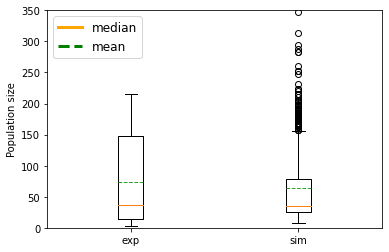

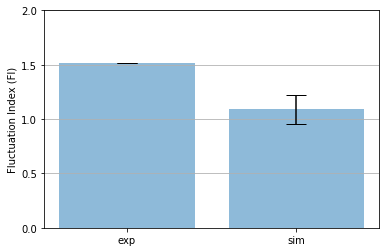

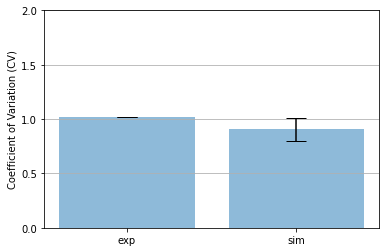

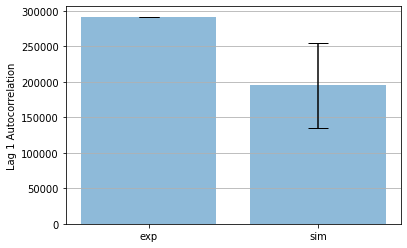

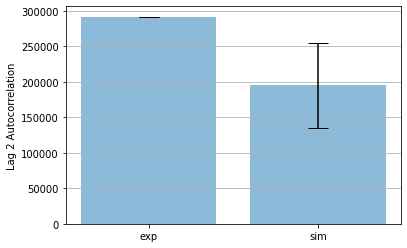

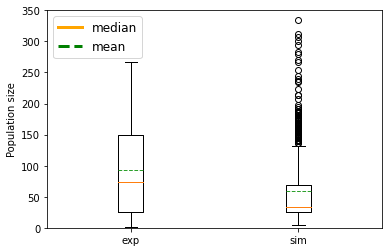

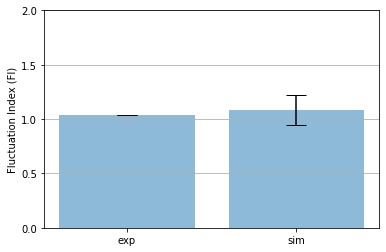

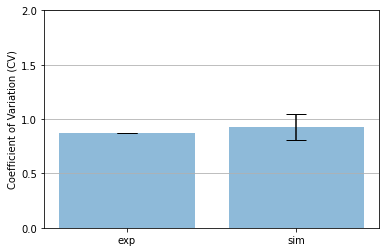

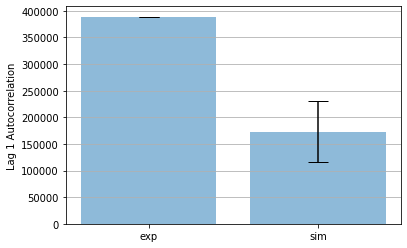

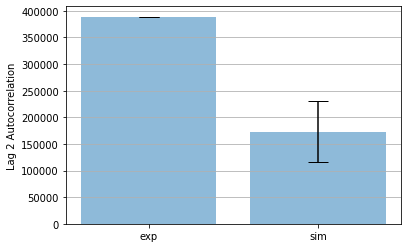

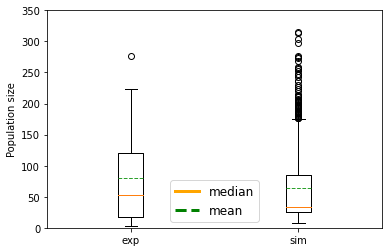

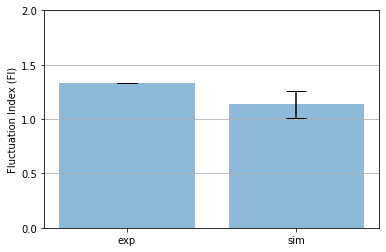

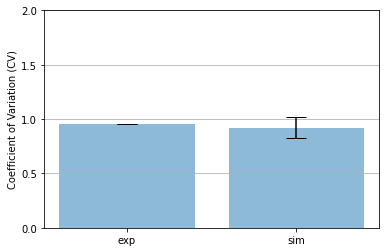

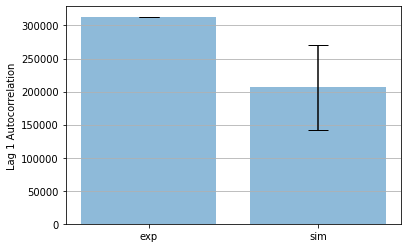

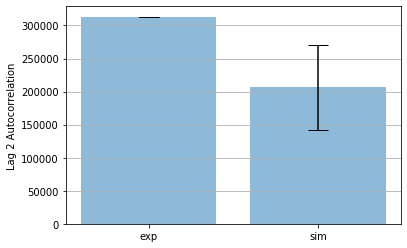

In [44]:
# read the data and validate on the validation sets

opt_params_arr = np.zeros([3,4]) 

for i in range(1,4):
    cost_funcn_arr = np.loadtxt(f"cv_metapop_metapop\cost_function_array_valid{i}.csv",delimiter=",")
    opt_params_arr[i-1,:] = cost_funcn_arr[np.argmin(cost_funcn_arr[:,4]),0:4]

# run the simulation with the optimum parameters and plot the validation set and the simulation set
for i in range(3):
    food = opt_params_arr[i,0]
    sen_adden = opt_params_arr[i,1]
    sen_adsize = opt_params_arr[i,2]
    adnut = opt_params_arr[i,3]
    f = 0.45
    generations = 26
    replicates = 25
    numegg = 18
    LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
    LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)

    # plot validation set and simulation set

    plot_validation(migration_45_metapop_nadult_matrix[:,i],LHLH_metapop_nadult_matrix)

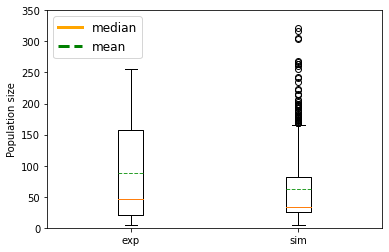

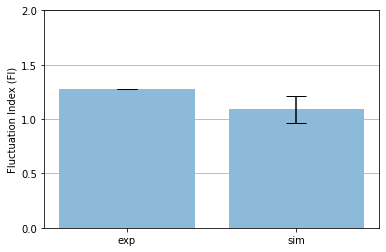

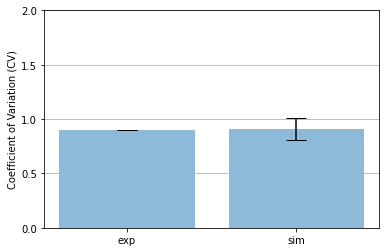

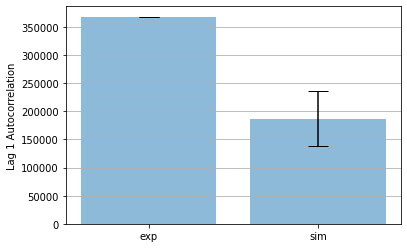

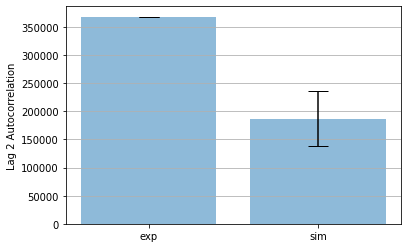

In [45]:
# avg of the optimum parameters and test on metapop 4
avg_optimum_params = np.mean(opt_params_arr,axis = 0)
food = avg_optimum_params[0]
sen_adden = avg_optimum_params[1]
sen_adsize = avg_optimum_params[2]
adnut = avg_optimum_params[3]
f = 0.45
generations = 26
replicates = 25
numegg = 18
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)

# plot test set and simulation set
plot_validation(migration_45_metapop_nadult_matrix[:,3],LHLH_metapop_nadult_matrix)

### Asymm data

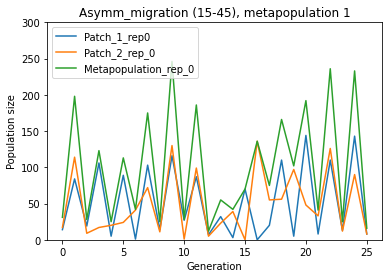

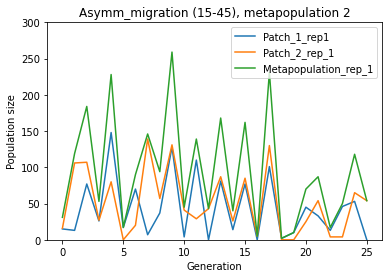

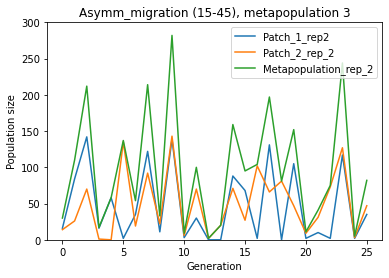

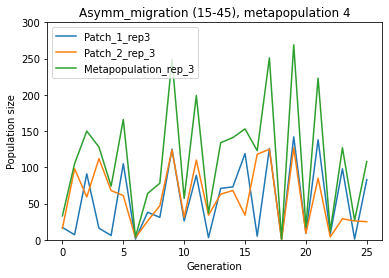

In [38]:
asymm_data = pd.read_excel("LHLH_data.xls",sheet_name="Asymm_migration")
Asymm_migration_nadult_matrix1, Asymm_migration_nadult_matrix2, Asymm_migration_metapop_nadult_matrix, Asymm_migration_extinctions_matrix1, Asymm_migration_extinctions_matrix2, Asymm_migration_metapop_extinctions_matrix = patch_data(asymm_data)
Asymm_migration_metapop_nadult_matrix = Metapop_numadult_matrix(Asymm_migration_nadult_matrix1,Asymm_migration_nadult_matrix2)
# plotting the time series for 15% migration

for i in range(4):
    plt.title(f"Asymm_migration (15-45), metapopulation {i+1}")
    plt.ylim(0,300)
    plot_time_series(Asymm_migration_nadult_matrix1,Asymm_migration_nadult_matrix2,Asymm_migration_metapop_nadult_matrix,[i])

In [114]:
#test parameters from 45% migration on 15% migration


food = 2.36
sen_adden = 0.065
sen_adsize = 1.25
adnut = 1.15
generations = 26
replicates = 50
f = 0.15
LHLH_numadult_matrix1,LHLH_numegg_matrix1,LHLH_extinctions_matrix1,LHLH_numadult_matrix2,LHLH_numegg_matrix2,LHLH_extinctions_matrix2 = Metapop_Simulation(numegg,food,adnut,numegg,food,adnut,generations,replicates)
LHLH_metapop_nadult_matrix = Metapop_numadult_matrix(LHLH_numadult_matrix1,LHLH_numadult_matrix2)
# calculate cost function between patch j of the experimental data and the whole of simulation data
cost = cost_function(migration_15_metapop_nadult_matrix, LHLH_metapop_nadult_matrix)
print(cost)

0.9717049723473139
